# Librería adtk para detección de anomalías en series temporales

In [1]:
!pip install adtk -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00


In [2]:
COLAB = True

In [3]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1B3hwgvxCQBapt3YForI6KadSDeGLxKsD',
                                        dest_path='./data.zip', unzip=True)

Unzipping...Done.


In [4]:
import pandas as pd

## 1. Objetos Detector

### ThresholdAD

`ThresholdAD` compara cada valor de la serie temporal con unos umbrales determinados.

En el siguiente ejemplo, detectamos los puntos temporales en los que la temperatura es superior a 30ºC o inferior a 15ºC.

In [5]:
s = pd.read_csv('./data/temperature.csv', index_col="Time", parse_dates=True, squeeze=True)
from adtk.data import validate_series
s = validate_series(s)

<ipython-input-5-bb2ea05a7cf7>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/temperature.csv', index_col="Time", parse_dates=True, squeeze=True)


In [6]:
s

Time
2017-05-02 00:00:00    18.91
2017-05-02 01:00:00    19.91
2017-05-02 02:00:00    20.19
2017-05-02 03:00:00    18.69
2017-05-02 04:00:00    18.11
                       ...  
2017-05-10 03:00:00    21.70
2017-05-10 04:00:00    21.43
2017-05-10 05:00:00    21.32
2017-05-10 06:00:00    20.98
2017-05-10 07:00:00    20.76
Freq: H, Name: Temperature (C), Length: 200, dtype: float64

In [7]:
from adtk.detector import ThresholdAD
threshold_ad = ThresholdAD(high=30, low=15)
anomalies = threshold_ad.detect(s)

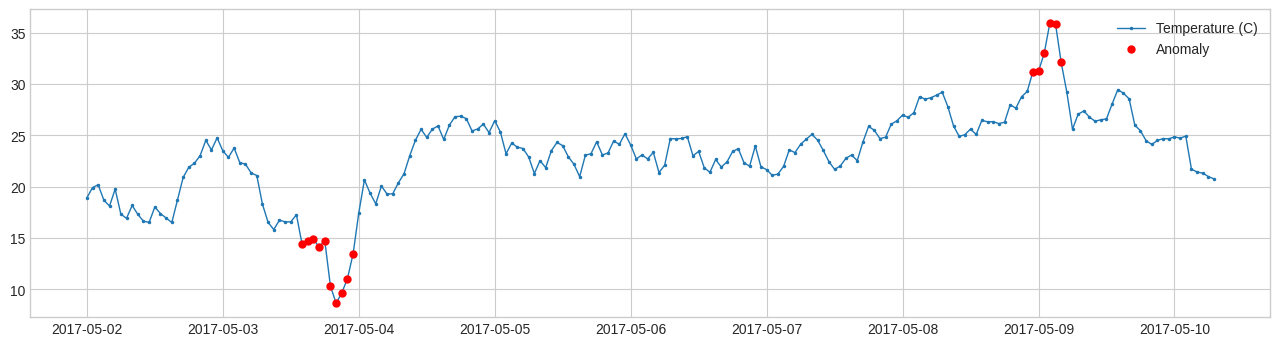

In [8]:
from adtk.visualization import plot
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### QuantileAD

`QuantileAD` compara cada valor de la serie temporal con los cuantiles históricos.

En el siguiente ejemplo, detectamos los puntos temporales en los que la temperatura está por encima del percentil 99% o por debajo del percentil 1%.

In [9]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)

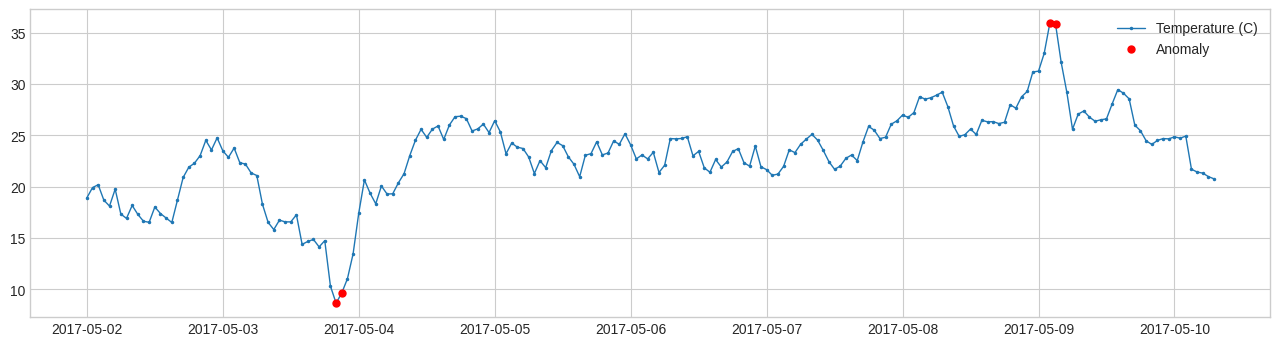

In [10]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### InterQuartileRangeAD

`InterQuartileRangeAD` es otro detector muy utilizado basado en estadísticos históricos sencillos, que se basa en el rango intercuartil (IQR). Cuando un valor está fuera del rango definido por $[Q_1 - c \times IQR,\  Q_3 + c \times IQR]$ donde $IQR = Q_3 - Q_1$ es la diferencia entre el cuantil 75% y el cuantil 25%. Este detector suele ser preferible a QuantileAD en el caso de que sólo una pequeña parte de los datos de entrenamiento, o incluso ninguna, sea anómala.

In [11]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)

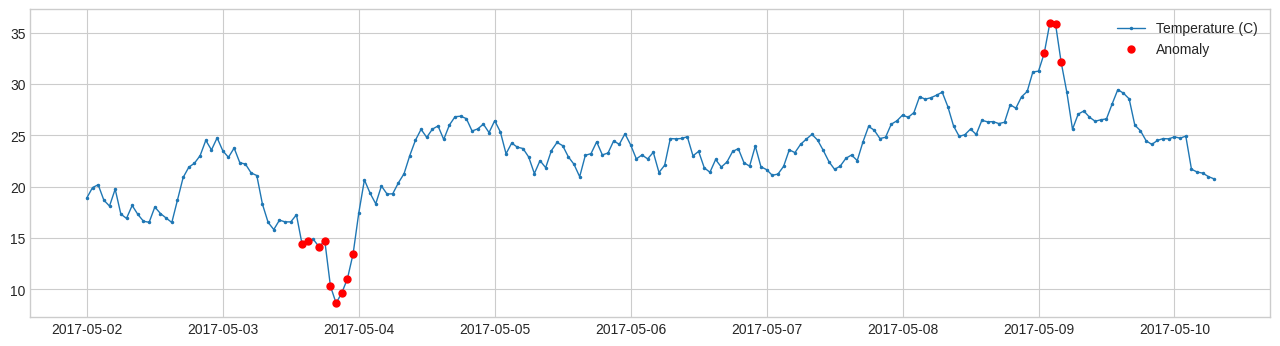

In [12]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### GeneralizedESDTestAD

`GeneralizedESDTestAD` detecta anomalías basándose en la prueba de desviación extrema generalizada (ESD).

Hay que tener en cuenta que una suposición que realiza la prueba ESD generalizada es que los valores no anómalos siguen una distribución aproximadamente Gaussiana.
Este detector sólo debería usarse cuando esta suposición se cumpla.

In [13]:
from adtk.detector import GeneralizedESDTestAD
esd_ad = GeneralizedESDTestAD(alpha=0.3)
anomalies = esd_ad.fit_detect(s)

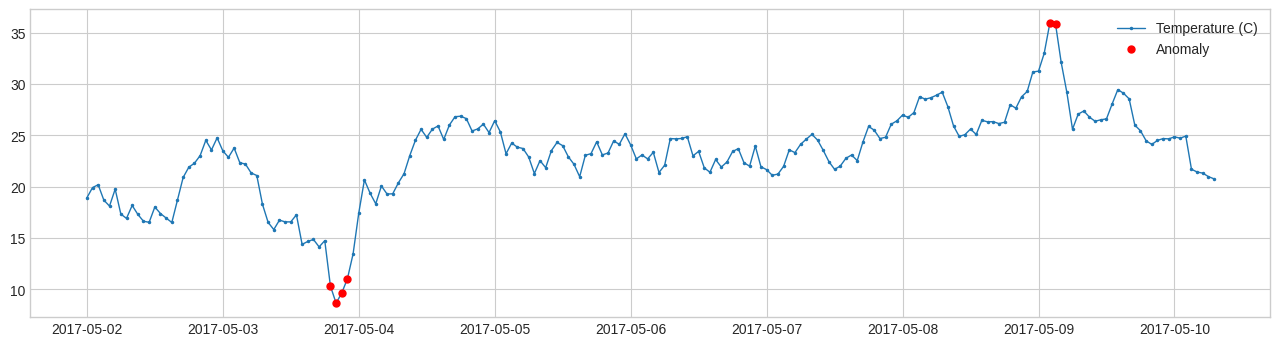

In [14]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### PersistAD

`PersistAD` compara cada valor de la serie temporal con sus valores anteriores. Internamente, se implementa como un [pipenet](#Pipenet) con transformer [DoubleRollingAggregate](#DoubleRollingAggregate).


En el siguiente ejemplo se detectan cambios positivos anómalos en el precio.

In [15]:
s = pd.read_csv('./data/price_short.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-15-8d901d19b0c0>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/price_short.csv', index_col="Time", parse_dates=True, squeeze=True)


/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


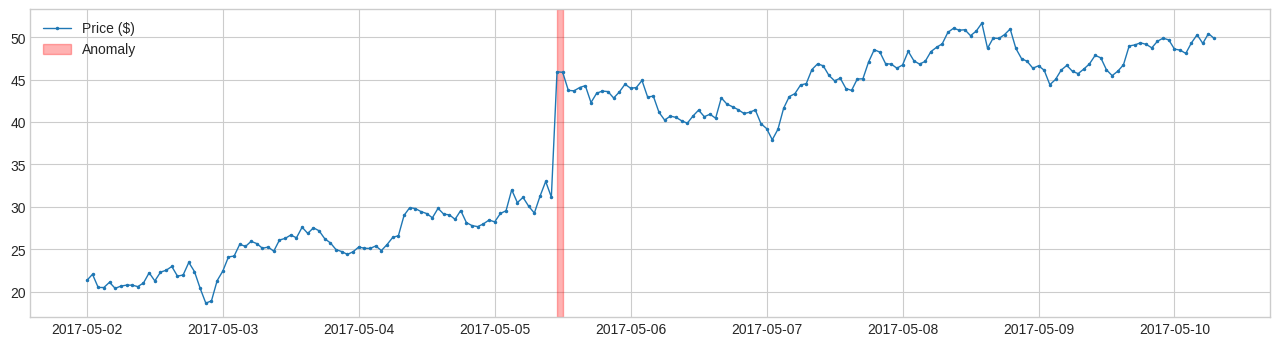

In [16]:
from adtk.detector import PersistAD
persist_ad = PersistAD(c=3.0, side='positive')
anomalies = persist_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red');

Por defecto `PersistAD` sólo comprueba un valor anterior, lo que es bueno para detectar anomalías aditivas a corto plazo pero no a largo plazo al ser demasiado miope.

En el siguiente ejemplo, no capta las caídas significativas del precio en una escala temporal más larga.

In [17]:
s = pd.read_csv('./data/price_long.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-17-9850e16e4b00>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/price_long.csv', index_col="Time", parse_dates=True, squeeze=True)


/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


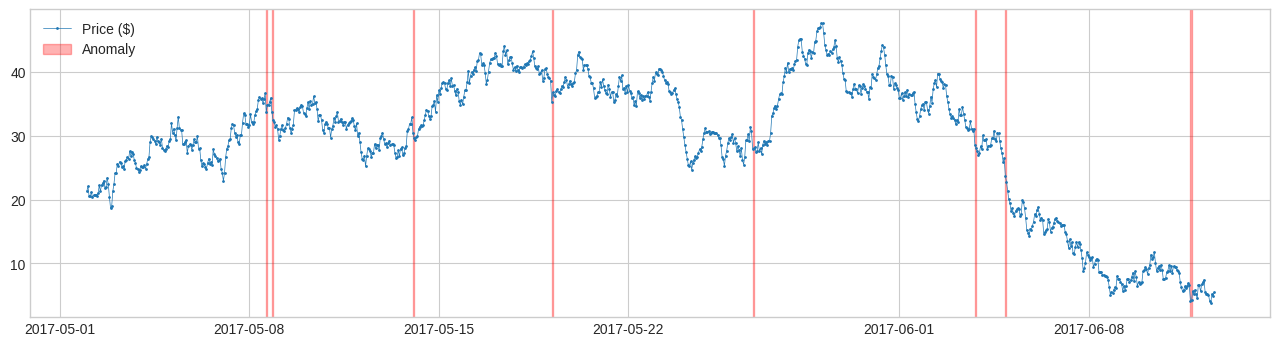

In [18]:
persist_ad = PersistAD(c=1.5, side='negative')
anomalies = persist_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

Podemos cambiar el parámetro `window` a un número superior a 1, y el detector comparará un valor con la mediana o la media de su ventana temporal anterior. Esto captará los cambios anómalos en la escala de medio a largo plazo, porque es menos miope. En el mismo ejemplo anterior, detecta con éxito las caídas de precio en la escala a largo plazo.

In [19]:
persist_ad.window = 24
anomalies = persist_ad.fit_detect(s)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


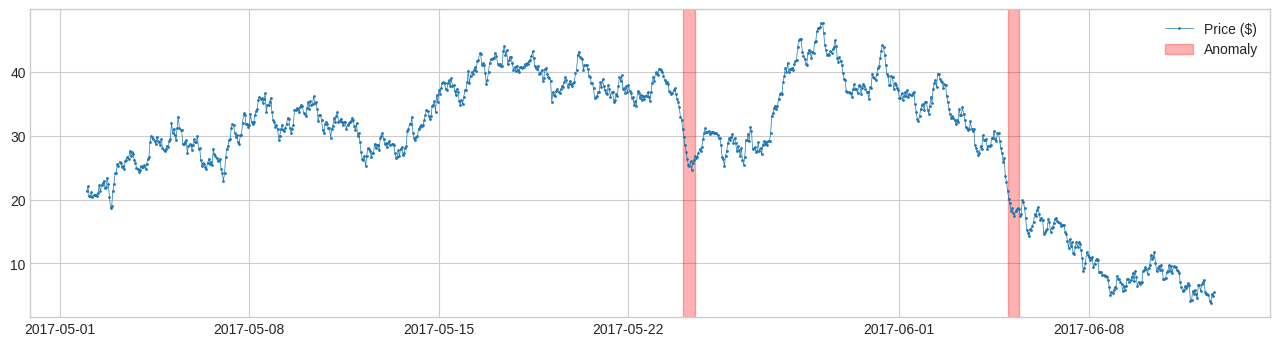

In [20]:
plot(s, anomaly=anomalies, anomaly_color='red');

### LevelShiftAD

`LevelShiftAD` detecta el cambio de nivel de los valores mediante el seguimiento de la diferencia entre los valores de la mediana en dos ventanas de tiempo deslizantes contiguas. No es sensible a los picos instantáneos y podría ser una buena opción si se producen con frecuencia valores atípicos ruidosos. Internamente, se implementa como un [pipenet](#Pipenet) con transformer [DoubleRollingAggregate](#DoubleRollingAggregate).

En el siguiente ejemplo, detectamos el punto de desplazamiento del uso de la CPU.

In [21]:
s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-21-8e6a518ae6d8>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)


/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


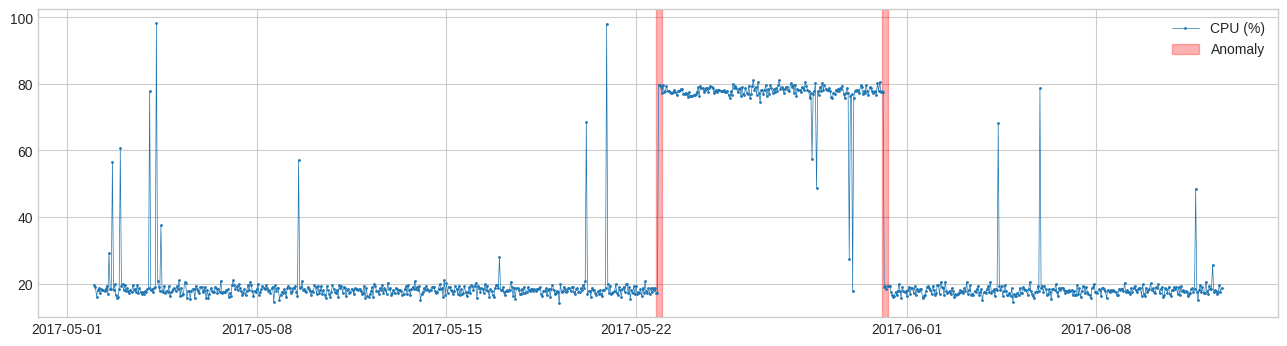

In [22]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=5)
anomalies = level_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

### VolatilityShiftAD

`VolatilityShiftAD` detecta el cambio del nivel de volatilidad mediante el seguimiento de la diferencia entre las desviaciones estándar en dos ventanas de tiempo deslizantes una al lado de la otra. Internamente, se implementa como un [pipenet](#Pipenet) con transformer [DoubleRollingAggregate](#DoubleRollingAggregate).

En el siguiente ejemplo, detectamos un desplazamiento positivo de la volatilidad de la amplitud sísmica que indica el inicio de un terremoto.

In [23]:
s = pd.read_csv('./data/seismic.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-23-ff547fe2e913>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/seismic.csv', index_col="Time", parse_dates=True, squeeze=True)


/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


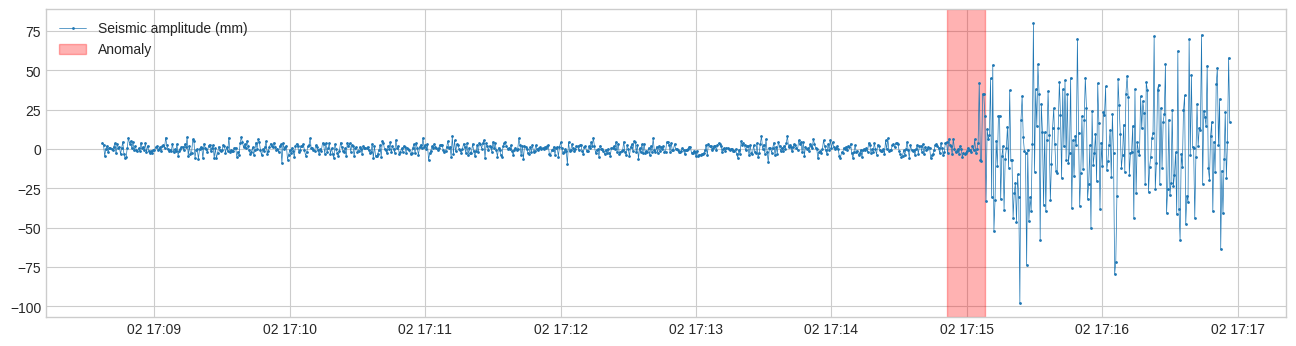

In [24]:
from adtk.detector import VolatilityShiftAD
volatility_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

### SeasonalAD

`SeasonalAD` detecta violaciones anómalas del patrón estacional. Internamente, se implementa como un [pipenet](#Pipenet) con transformer [ClassicSeasonalDecomposition](#ClassicSeasonalDecomposition).

En el siguiente ejemplo, detectamos un tráfico inusual, que se produce sobre todo en los días festivos importantes.

In [25]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-25-3b38f7002786>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)


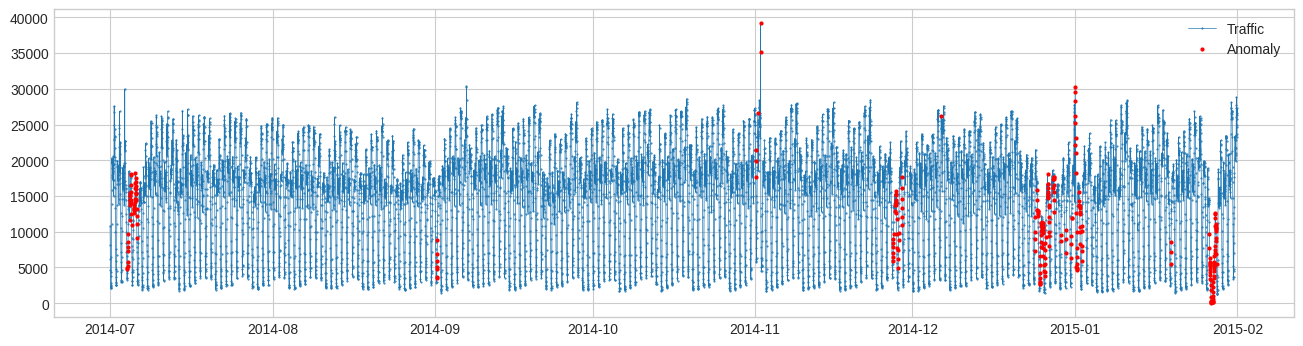

In [26]:
from adtk.detector import SeasonalAD
seasonal_ad = SeasonalAD(c=3.0, side="both")
anomalies = seasonal_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2);

### AutoregressionAD

`AutoregressionAD` detecta cambios anómalos de comportamiento autorregresivo en las series temporales. Internamente, se implementa como un [pipenet](#Pipenet) con transformers [Retrospect](#Retrospect) y [RegressionResidual](#RegressionResidual).

Para el mismo ejemplo anterior, detectamos la violación del comportamiento regresivo habitual en el historial de tráfico.

In [27]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-27-3b38f7002786>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)


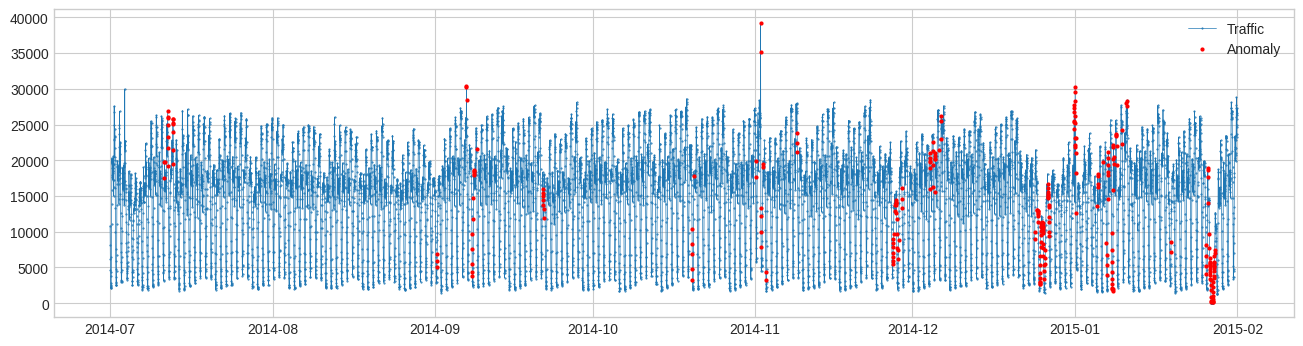

In [28]:
from adtk.detector import AutoregressionAD
autoregression_ad = AutoregressionAD(n_steps=7*2, step_size=24, c=3.0)
anomalies = autoregression_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2);

### MinClusterDetector

`MinClusterDetector` trata las series temporales multivariantes como puntos independientes en un espacio de alta dimensión, las divide en clusters e identifica los valores del cluster más pequeño como anómalos. Esto puede ayudar a capturar los valores atípicos en el espacio de alta dimensión.

En el siguiente ejemplo, detectamos los cambios anómalos de la relación entre la velocidad de un generador y la potencia generada. La violación de la relación regular indica un fallo del equipo.

In [29]:
df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True, squeeze=True)
df = validate_series(df)

<ipython-input-29-dc382fdce484>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True, squeeze=True)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


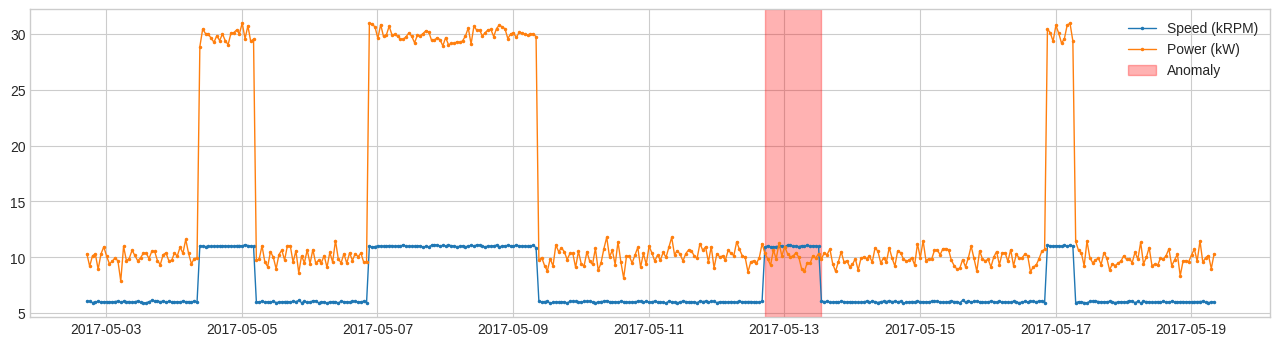

In [30]:
from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### OutlierDetector

`OutlierDetector` realiza la detección de valores atípicos multivariantes independientes del tiempo e identifica los valores atípicos como anomalías. El algoritmo de detección de valores atípicos multivariantes puede ser el de scikit-learn u otros paquetes que sigan la misma API.

Para el mismo ejemplo anterior, aplicamos `OutlierDetector` con un modelo LOF de scikit-learn.

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


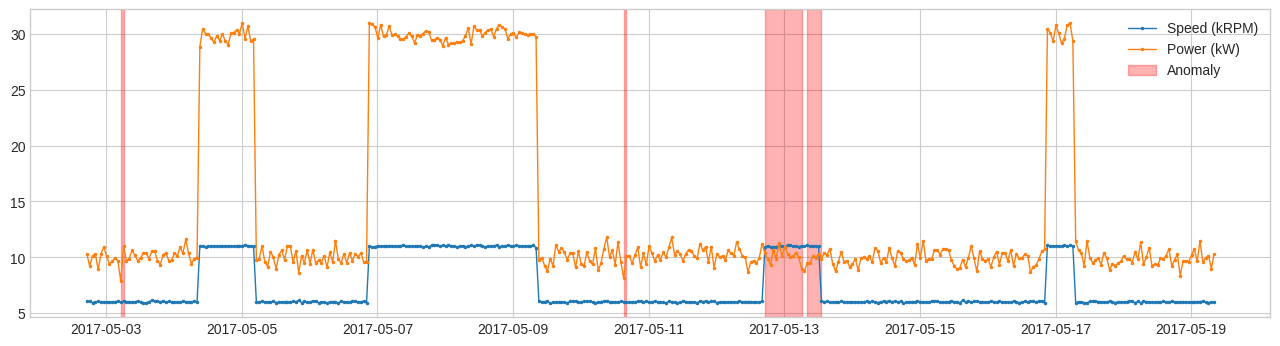

In [31]:
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### RegressionAD

`RegressionAD` detecta la violación anómala de la relación habitual entre series multivariantes mediante el seguimiento del error regresivo. Internamente, se implementa como un [pipenet](#Pipenet) con transformer [RegressionResidual](#RegressionResidual).

Para el mismo ejemplo anterior, aplicamos `RegressionAD` con un modelo de regresión lineal.

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


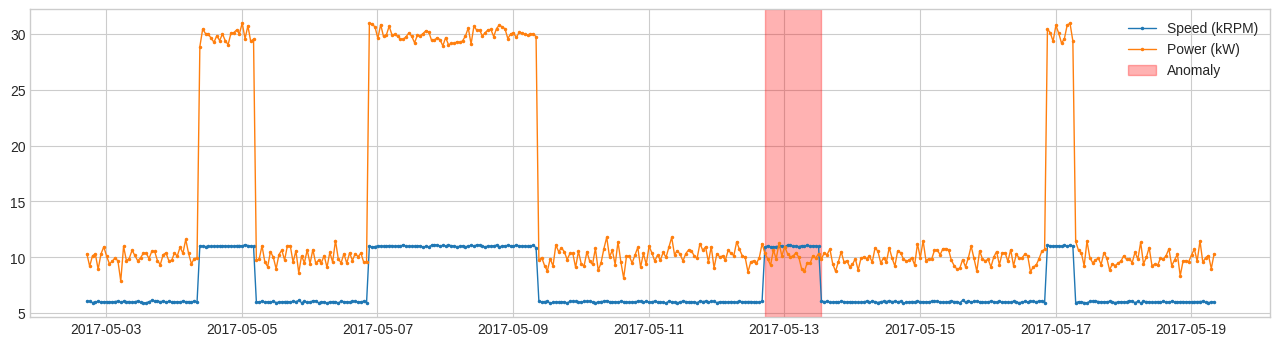

In [32]:
from adtk.detector import RegressionAD
from sklearn.linear_model import LinearRegression
regression_ad = RegressionAD(regressor=LinearRegression(), target="Speed (kRPM)", c=3.0)
anomalies = regression_ad.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### PcaAD

`PcaAD` realiza un análisis de componentes principales (PCA) a series temporales multivariantes (cada punto temporal como un vector en un espacio de alta dimensión) y rastrea el error de reconstrucción de esos vectores. Este detector puede ser útil cuando se supone que los puntos normales están en un colector de rango inferior mientras que los puntos anómalos no lo están. Internamente, se implementa como un [pipeline](#Pipeline) con transformer [PcaReconstructionError](#PcaReconstructionError).

Aplicamos `PcaAD` al mismo ejemplo anterior.

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


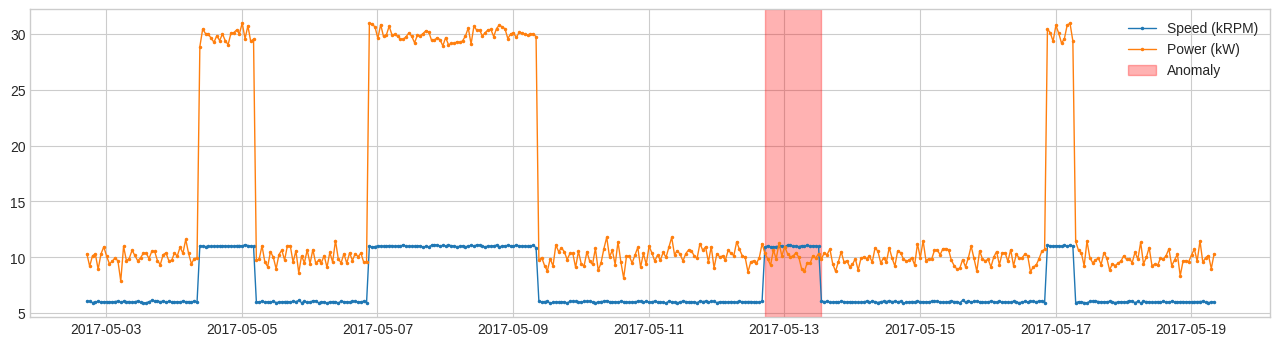

In [33]:
from adtk.detector import PcaAD
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### CustomizedDetector

`CustomizedDetector1D` y `CustomizedDetectorHD` ayudan al usuario a convertir una función en un objeto detector personalizado que puede ser utilizado (por un objeto `Pipeline`, por ejemplo) como otro objeto detector.

En el siguiente ejemplo, detectamos cuando la potencia generada (en kW) es inferior a 1.2 veces la velocidad del generador (en kRPM).

In [34]:
df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True)
df = validate_series(df)
df.head()

Speed (kRPM)  Power (kW)
Time                                         
2017-05-02 17:08:37      6.066579   10.308257
2017-05-02 18:08:37      6.035764    9.186763
2017-05-02 19:08:37      5.922730   10.128382
2017-05-02 20:08:37      5.999581   10.290300
2017-05-02 21:08:37      6.031067    8.910037

In [35]:
def myDetectionFunc(df):
    return (df["Speed (kRPM)"] * 1.2 > df["Power (kW)"])

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


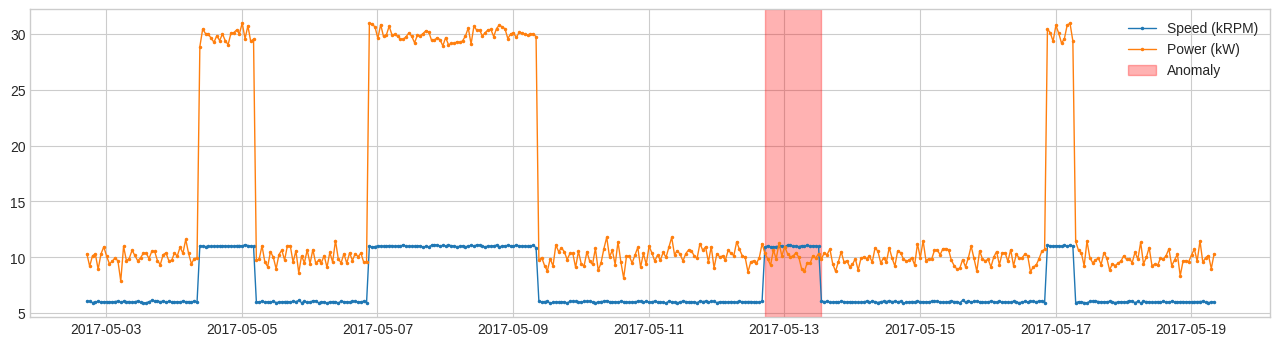

In [36]:
from adtk.detector import CustomizedDetectorHD
customized_detector = CustomizedDetectorHD(detect_func=myDetectionFunc)
anomalies = customized_detector.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

## 2. Objetos Transformer

### RollingAggregate

`RollingAggregate` va moviendo una ventana deslizante a lo largo de la serie temporal y calcula en cada ventana la operación seleccionada. Algunos ejemplos típicos son la media móvil, la desviación estándar móvil, etc.

En el siguiente ejemplo, hacemos un seguimiento del recuento de valores válidos a lo largo de una serie de tiempo, lo que puede ayudar a dar la alarma cuando los valores perdidos se producen con frecuencia.

<ipython-input-37-62d7c9ca5c10>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/pressure.csv', index_col="Time", parse_dates=True, squeeze=True)


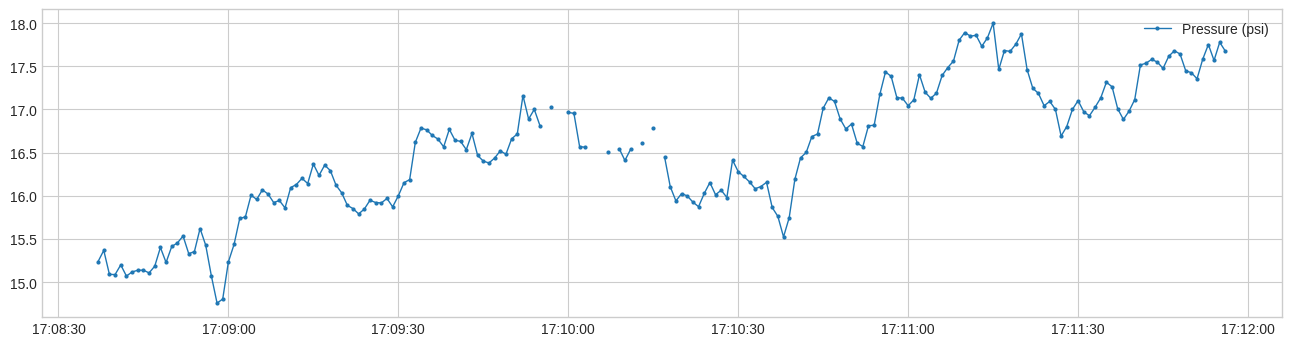

In [37]:
s = pd.read_csv('./data/pressure.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)
plot(s, ts_linewidth=1, ts_markersize=4);

/usr/local/lib/python3.10/dist-packages/adtk/transformer/_transformer_1d.py:285: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  s_rolling = rolling.agg(agg)


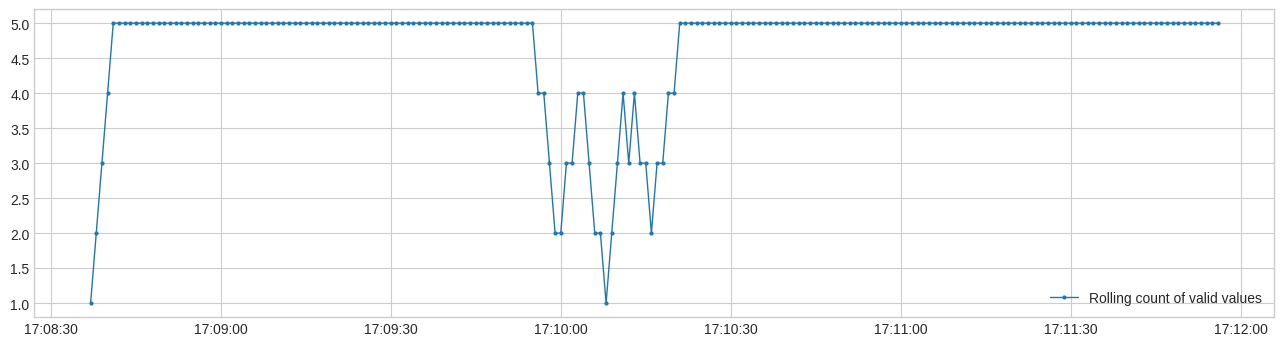

In [38]:
from adtk.transformer import RollingAggregate
s_transformed = RollingAggregate(agg='count', window=5).transform(s)
plot(s_transformed.rename("Rolling count of valid values"), ts_linewidth=1, ts_markersize=4);

### DoubleRollingAggregate

`DoubleRollingAggregate` va moviendo dos ventanas deslizantes, una al lado de la otra, a lo largo de la serie temporal, calcula en ellas la métrica seleccionada, y rastrea la diferencia entre las métricas de las dos ventanas. Esto puede ayudar a seguir los cambios de comportamiento estadístico en una serie temporal.

En el siguiente ejemplo, rastreamos el cambio de la distribución estadística de los valores de la serie.

<ipython-input-39-ff190e830317>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/seismic.csv', index_col="Time", parse_dates=True, squeeze=True)


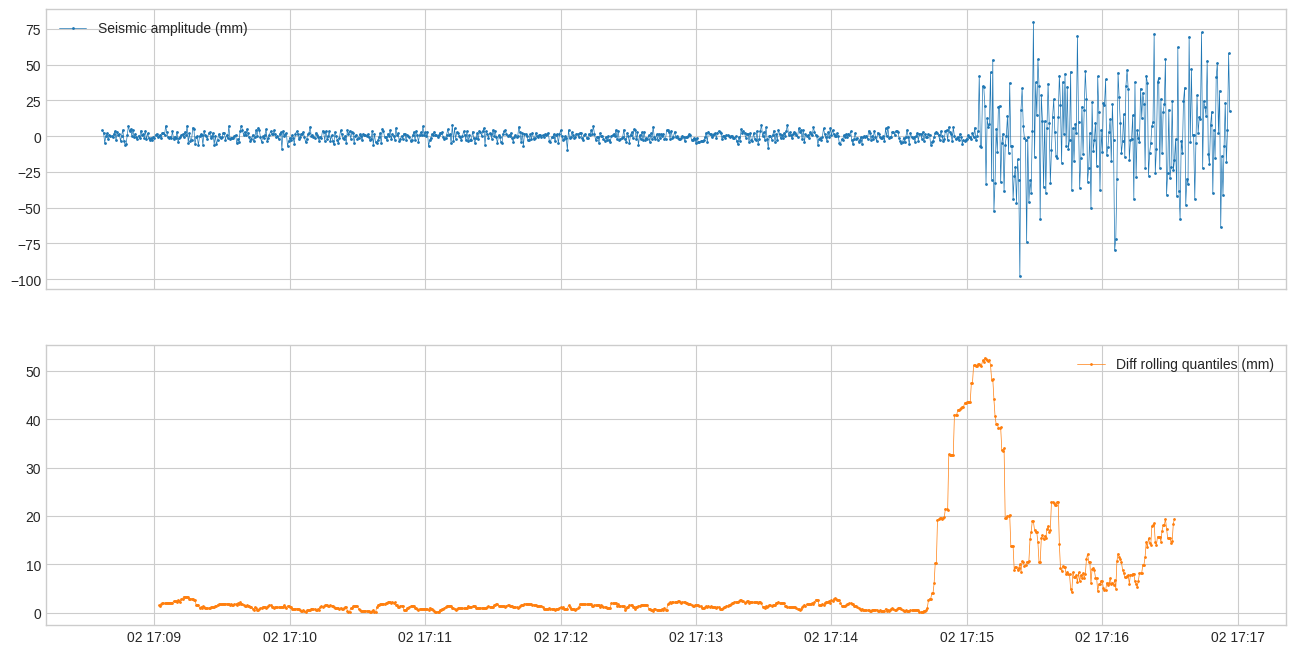

In [39]:
s = pd.read_csv('./data/seismic.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="quantile",
    agg_params={"q": [0.1, 0.5, 0.9]},
    window=50,
    diff="l2").transform(s).rename("Diff rolling quantiles (mm)")

plot(pd.concat([s, s_transformed], axis=1));

En el siguiente ejemplo, seguimos el desplazamiento del nivel de valor.

In [40]:
s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-40-8e6a518ae6d8>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)


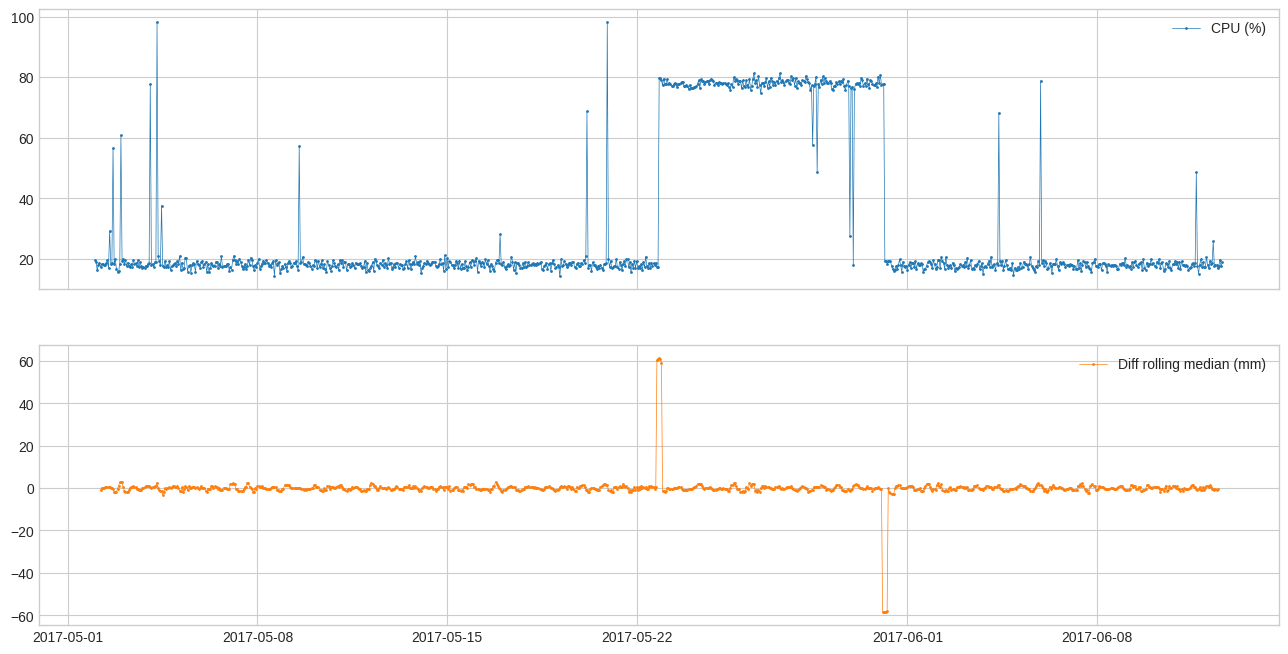

In [41]:
from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="median",
    window=5,
    diff="diff").transform(s).rename("Diff rolling median (mm)")

plot(pd.concat([s, s_transformed], axis=1));

En el siguiente ejemplo, seguimos los cambios anómalos del precio ajustando el parámetro **window**.

In [42]:
s = pd.read_csv('./data/price_short.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-42-8d901d19b0c0>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/price_short.csv', index_col="Time", parse_dates=True, squeeze=True)


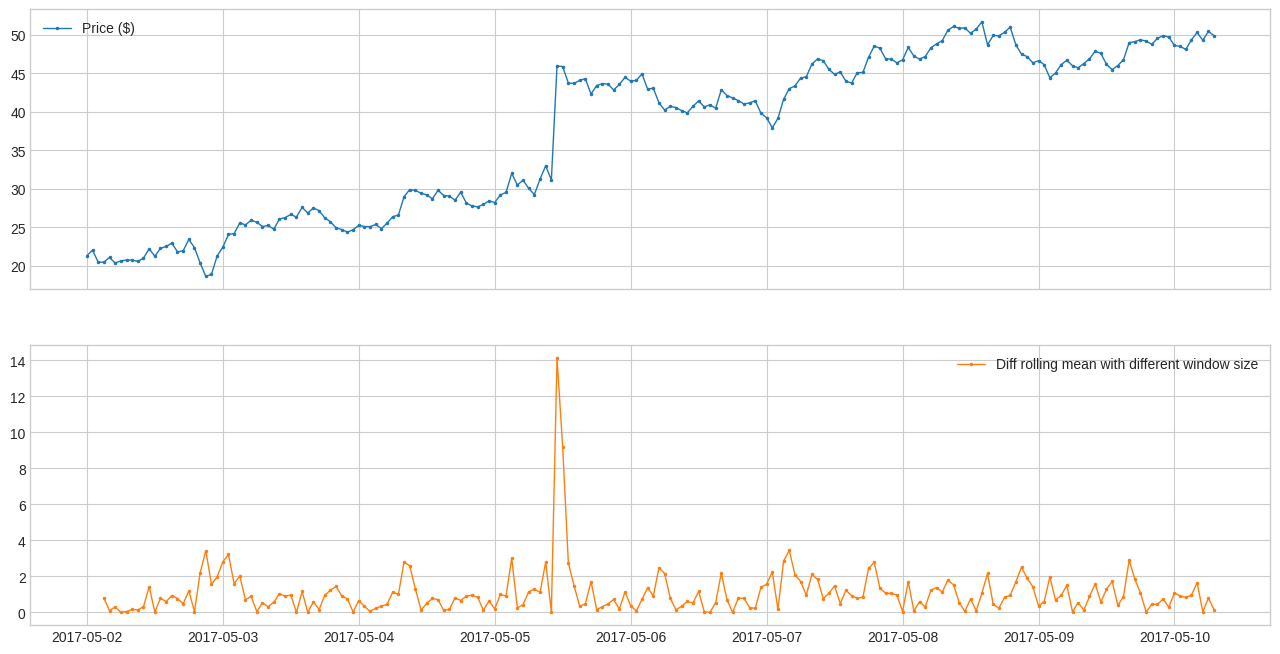

In [43]:
from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="mean",
    window=(3,1), #The tuple specifies the left window to be 3, and right window to be 1
    diff="l1").transform(s).rename("Diff rolling mean with different window size")

plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=3);

### ClassicSeasonalDecomposition

`ClassicSeasonalDecomposition` descompone una serie en una parte de tendencia (opcional), una parte estacional y una parte residual. La parte residual puede ayudar a identificar la desviación anómala del patrón estacional.

En el siguiente ejemplo, calculamos la desviación del patrón de tráfico habitual a lo largo de la serie, lo que puede ayudar a identificar el tráfico inusual.

In [44]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-44-3b38f7002786>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)


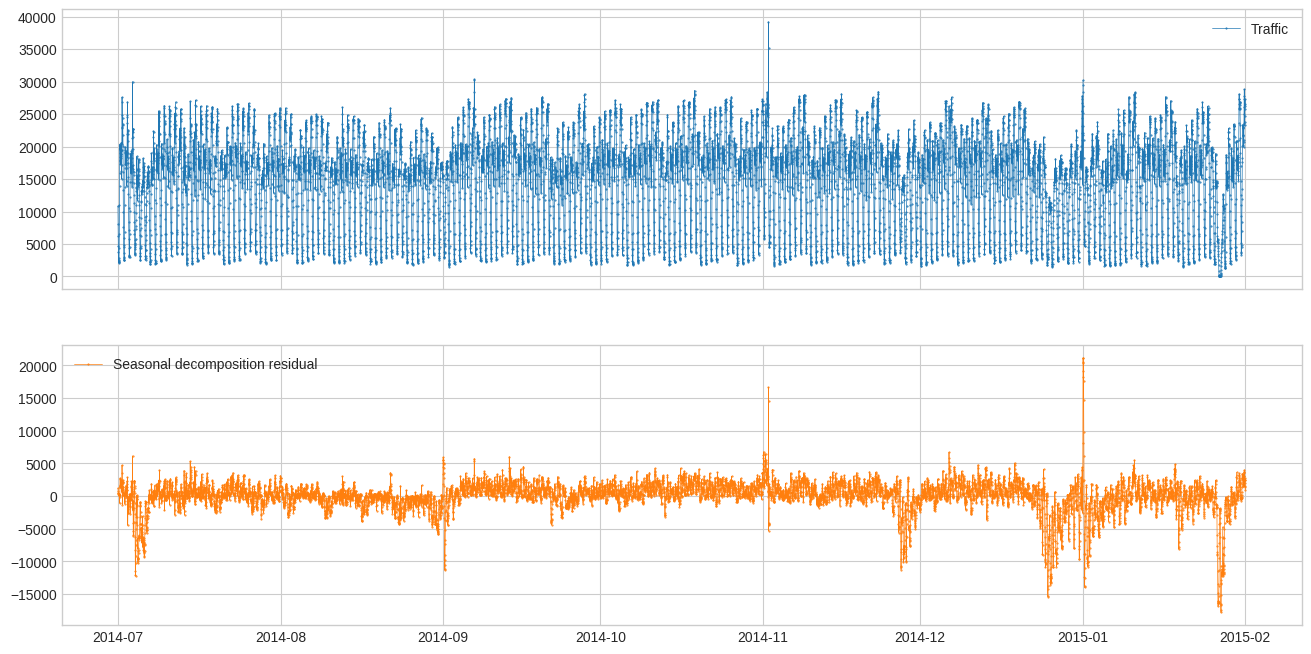

In [45]:
from adtk.transformer import ClassicSeasonalDecomposition
s_transformed = ClassicSeasonalDecomposition().fit_transform(s).rename("Seasonal decomposition residual")
plot(pd.concat([s, s_transformed], axis=1), ts_markersize=1);

`ClassicSeasonalDecomposition` sin extraer la tendencia no podría manejar los casos en los que la tendencia a largo plazo se mezcla con el patrón estacional, así como el ruido. En esos casos, la opción `trend` debería estar activada.

En el siguiente ejemplo, `ClassicSeasonalDecomposition` no consigue descomponer las series residuales y la tendencia a largo plazo de una serie sintética sin la opción `trend` activada.

In [46]:
s = pd.read_csv('./data/seasonal+trend.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-46-13ab0421dc89>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/seasonal+trend.csv', index_col="Time", parse_dates=True, squeeze=True)


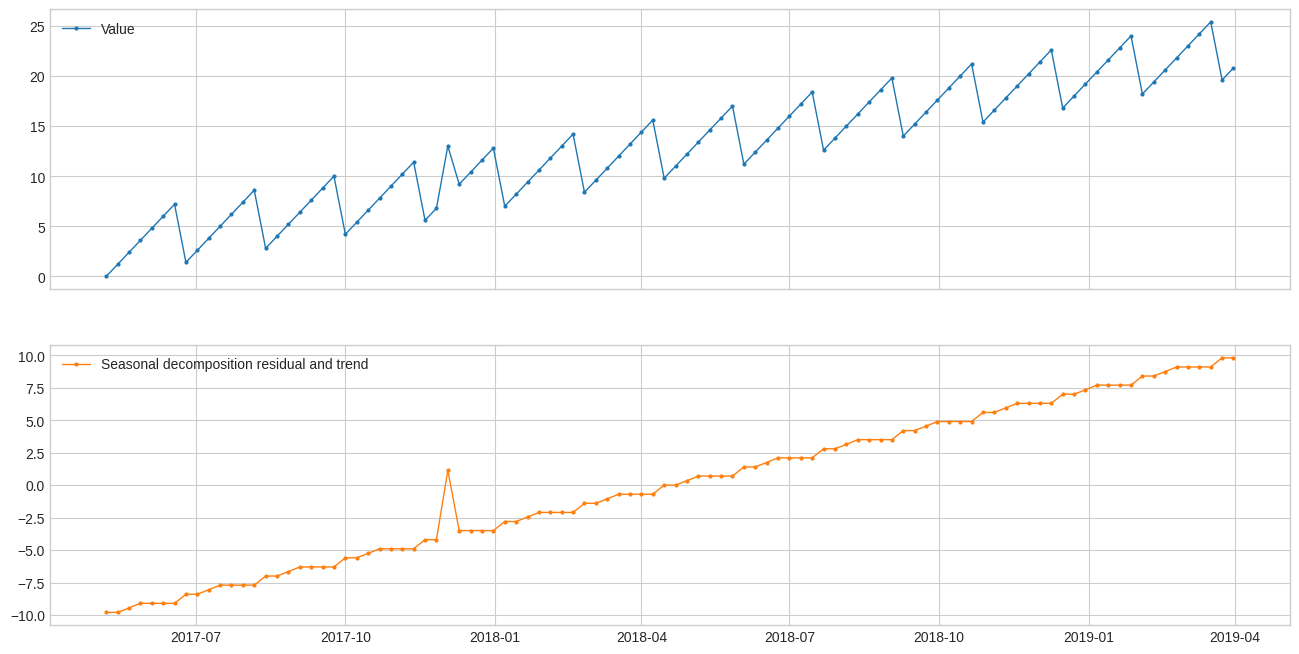

In [47]:
s_transformed = ClassicSeasonalDecomposition(freq=7).fit_transform(s).rename("Seasonal decomposition residual and trend")
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=4);

Activamos la opción `trend` del modelo y volvemos a aplicarlo al mismo ejemplo anterior, en el que se separa el residuo de la tendencia.

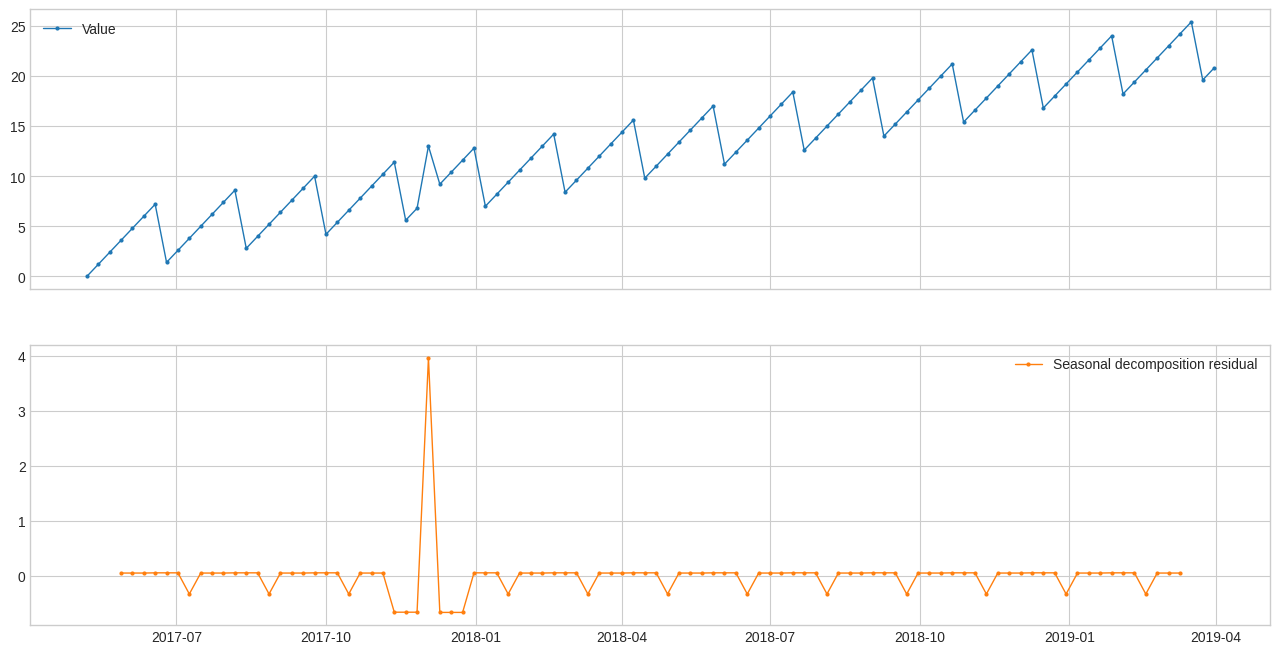

In [48]:
s_transformed = ClassicSeasonalDecomposition(freq=7, trend=True).fit_transform(s).rename("Seasonal decomposition residual")
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=4);

### Retrospect

`Retrospect` devuelve un dataframe con valores retrospectivos, es decir, la fila en el instante t incluye los valores en (t-k), donde los k son especificados por el usuario. Este transformer puede ser útil para los casos en los que debe tenerse en cuenta el efecto  retardo.

En el siguiente ejemplo, creamos un dataframe retrospectivo para una serie sintética.

In [49]:
s = pd.read_csv('./data/sin.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

<ipython-input-49-0538d9dd2d76>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/sin.csv', index_col="Time", parse_dates=True, squeeze=True)


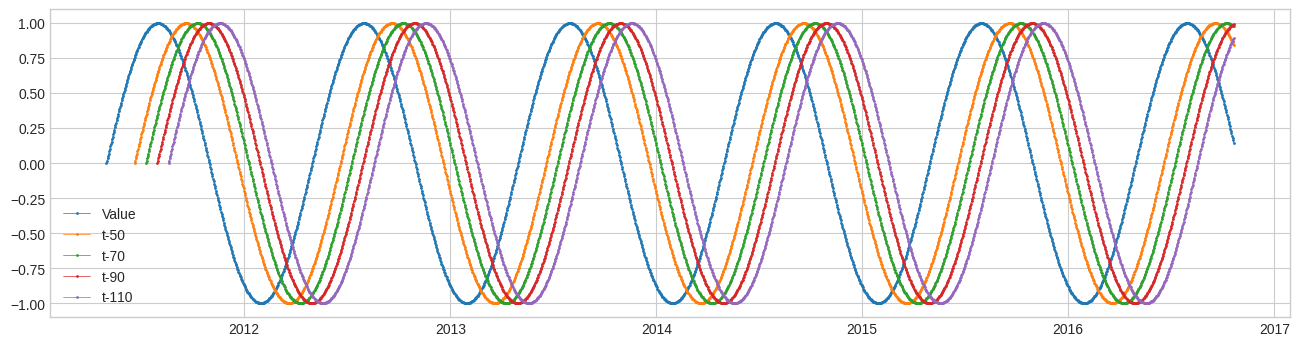

In [50]:
from adtk.transformer import Retrospect
df = Retrospect(n_steps=4, step_size=20, till=50).transform(s)
plot(pd.concat([s, df], axis=1), curve_group="all");

In [51]:
df

t-50      t-70      t-90     t-110
Time                                              
2011-05-02       NaN       NaN       NaN       NaN
2011-05-03       NaN       NaN       NaN       NaN
2011-05-04       NaN       NaN       NaN       NaN
2011-05-05       NaN       NaN       NaN       NaN
2011-05-06       NaN       NaN       NaN       NaN
...              ...       ...       ...       ...
2016-10-17  0.880012  0.988678  0.981306  0.858764
2016-10-18  0.871706  0.985948  0.984474  0.867456
2016-10-19  0.863142  0.982927  0.987349  0.875892
2016-10-20  0.854322  0.979614  0.989932  0.884068
2016-10-21  0.845249  0.976011  0.992222  0.891981

[2000 rows x 4 columns]

### RegressionResidual

`RegressionResidual` performs regression to a multivariate series and returns regressive residual. This may help identifying anomalous violation of usual relationship between series.

In the following example, we track deviation of series from usual correlation between generator speed and power.

In [52]:
df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True)
df = validate_series(df)

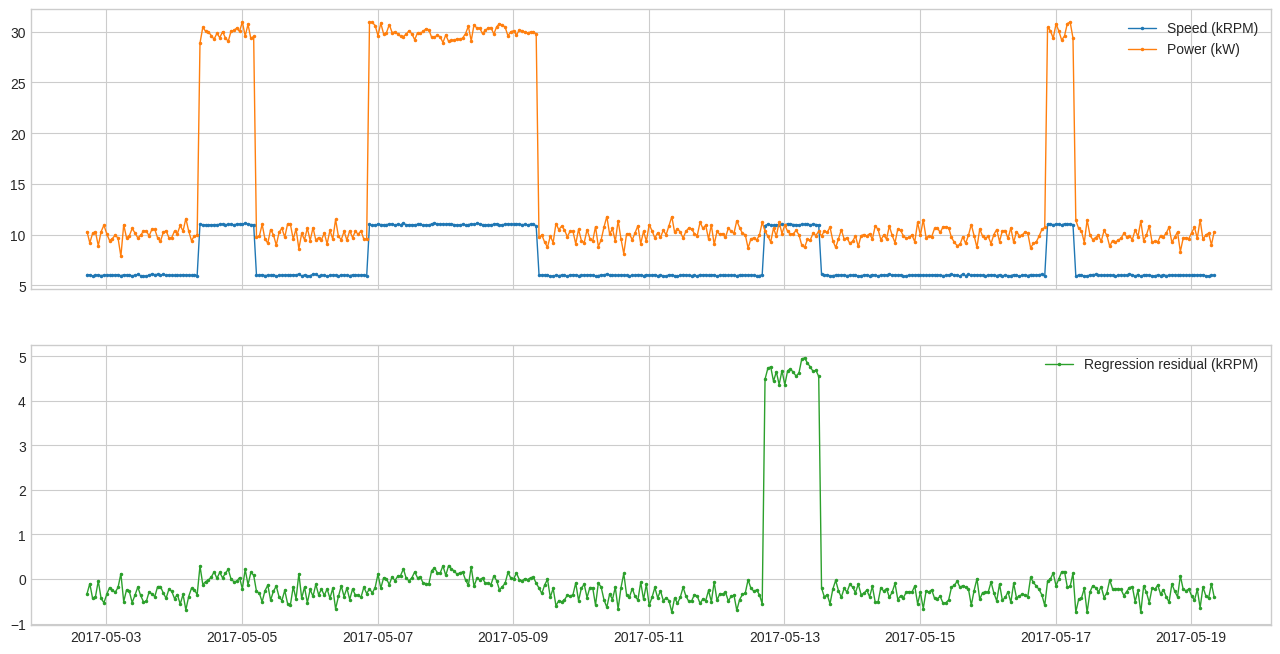

In [53]:
from adtk.transformer import RegressionResidual
s = RegressionResidual(regressor=LinearRegression(), target="Speed (kRPM)").fit_transform(df).rename("Regression residual (kRPM)")
plot(pd.concat([df, s], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), "Regression residual (kRPM)"]);

### PcaProjection

`PcaProjection` transforma una serie multivariable en una representación con los primeros k componentes principales.

En el siguiente ejemplo, transformamos la serie bidimensional utilizada en el ejemplo anterior en una dimensión manteniendo únicamente su primer coeficiente principal.

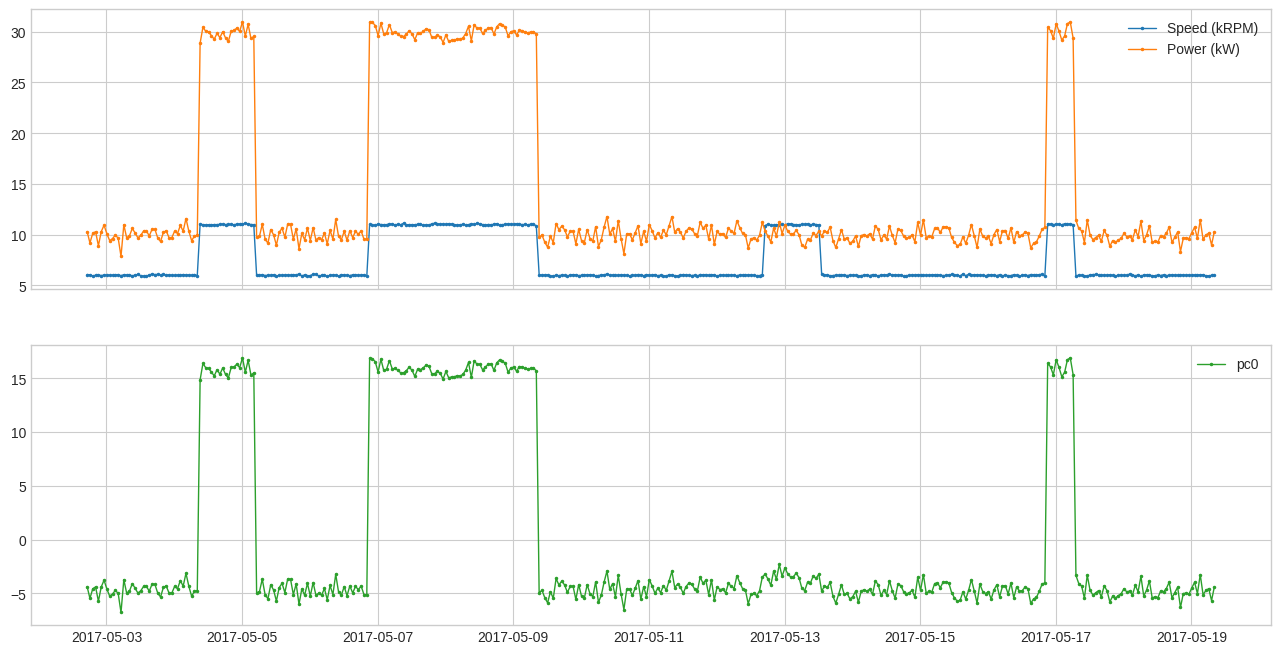

In [54]:
from adtk.transformer import PcaProjection
s = PcaProjection(k=1).fit_transform(df)
plot(pd.concat([df, s], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), "pc0"]);

### PcaReconstruction

`PcaReconstruction` proyecta una serie multivariante sobre el hiperplano que abarcan sus primeras k componentes principales.

En el siguiente ejemplo, proyectamos la serie bidimensional utilizada en el ejemplo anterior sobre la línea de su primer componente principal.

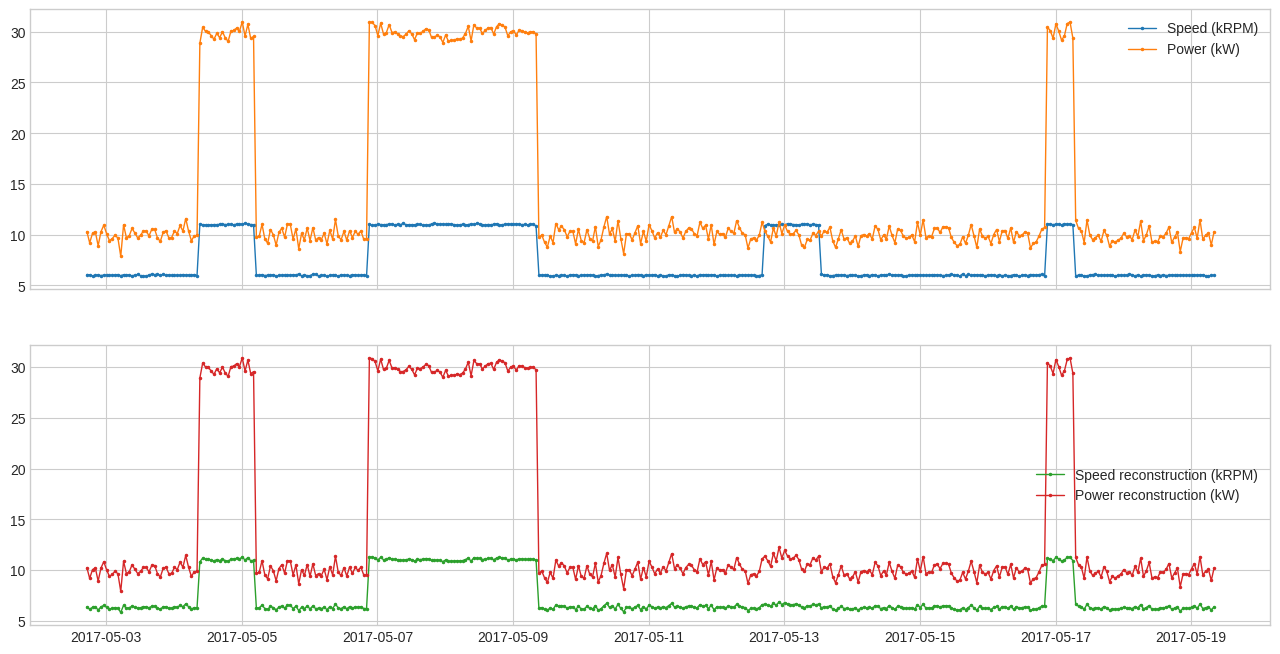

In [55]:
from adtk.transformer import PcaReconstruction
df_transformed = PcaReconstruction(k=1).fit_transform(df).rename(columns={"Speed (kRPM)": "Speed reconstruction (kRPM)", "Power (kW)": "Power reconstruction (kW)"})
plot(pd.concat([df, df_transformed], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), ("Speed reconstruction (kRPM)", "Power reconstruction (kW)")]);

### PcaReconstructionError

`PcaReconstructionError` proyecta una serie multivariante sobre el hiperplano abarcado por sus primeras k componentes principales y devuelve el error que indica la distancia entre el punto de datos y el subespacio de rango inferior de las primeras k componentes principales.

En el siguiente ejemplo, proyectamos la serie bidimensional utilizada en el ejemplo anterior sobre la línea de su primer componente principal.

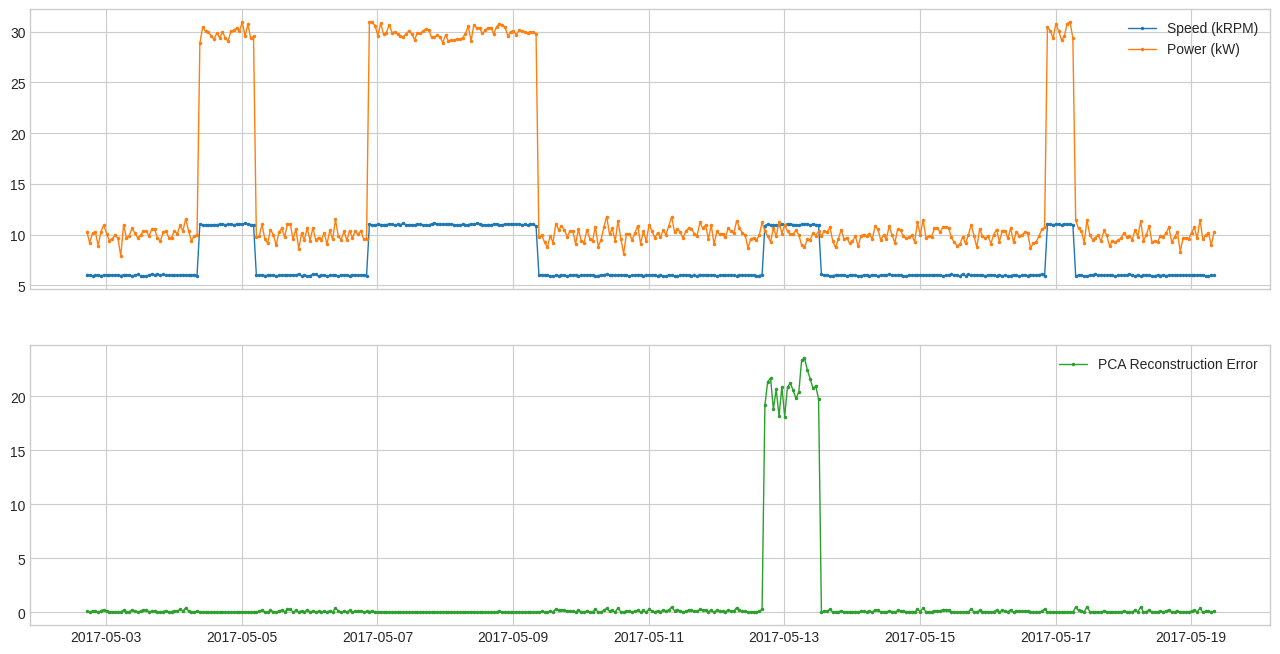

In [56]:
from adtk.transformer import PcaReconstructionError
s = PcaReconstructionError(k=1).fit_transform(df).rename("PCA Reconstruction Error")
plot(pd.concat([df, s], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), "PCA Reconstruction Error"]);

### CustomizedTransformer

Al igual que un detector personalizado, un usuario puede convertir una función en un transformador personalizado con `CustomizedTransformer1D` o `CustomizedTransformerHD`, para que pueda ser utilizado por un objeto `Pipe`.

En el siguiente ejemplo, obtenemos una serie calculada de la potencia generada (en kW) dividida por la velocidad del generador (en kRPM).

In [57]:
df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True)
df = validate_series(df)

In [58]:
def myTransformationFunc(df):
    return (df["Power (kW)"] / df["Speed (kRPM)"]).rename("Power/Speed (kW/kRPM)")

In [59]:
pd.concat([df, s], axis=1)

Speed (kRPM)  Power (kW)  PCA Reconstruction Error
Time                                                                   
2017-05-02 17:08:37      6.066579   10.308257                  0.097240
2017-05-02 18:08:37      6.035764    9.186763                  0.006847
2017-05-02 19:08:37      5.922730   10.128382                  0.168298
2017-05-02 20:08:37      5.999581   10.290300                  0.139034
2017-05-02 21:08:37      6.031067    8.910037                  0.000547
...                           ...         ...                       ...
2017-05-19 04:08:37      6.040213    9.531571                  0.024986
2017-05-19 05:08:37      5.948470    9.959600                  0.119861
2017-05-19 06:08:37      5.932115   10.144819                  0.163950
2017-05-19 07:08:37      5.986675    8.983310                  0.006974
2017-05-19 08:08:37      5.991435   10.305261                  0.147651

[400 rows x 3 columns]

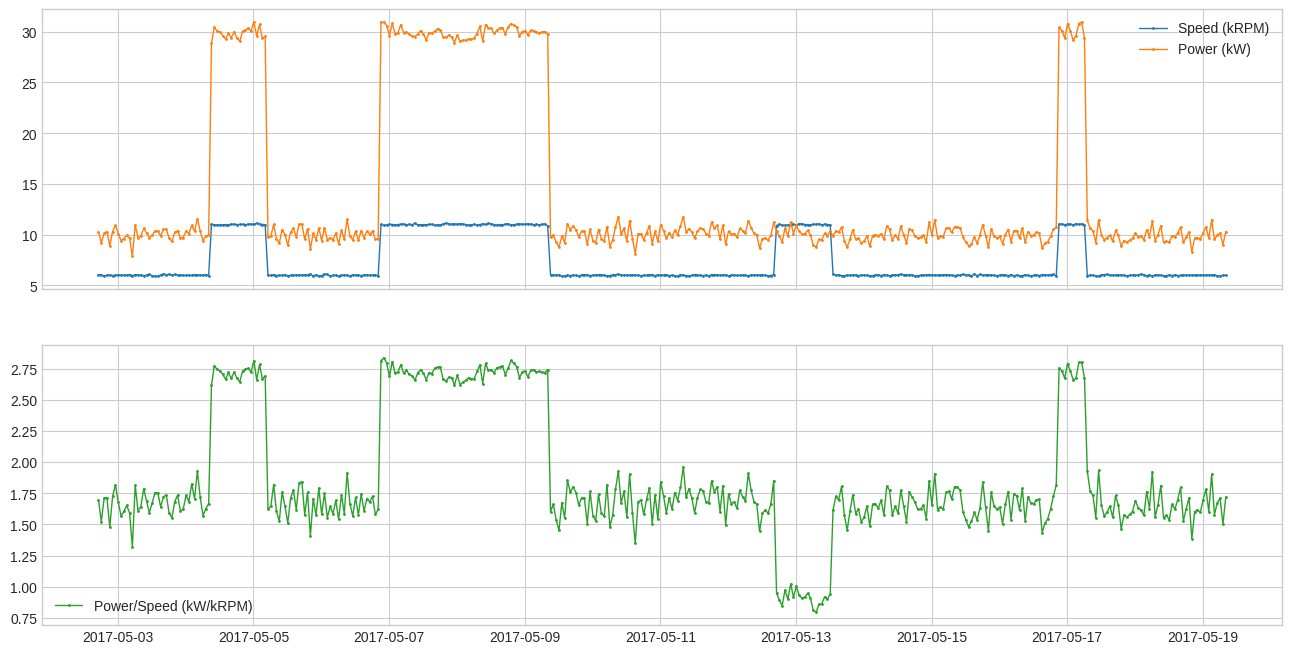

In [60]:
from adtk.transformer import CustomizedTransformerHD
customized_transformer = CustomizedTransformerHD(transform_func=myTransformationFunc)
s = customized_transformer.transform(df)
plot(pd.concat([df, s], axis=1), ts_linewidth=1, curve_group=[("Speed (kRPM)", "Power (kW)"), "Power/Speed (kW/kRPM)"]);

## Aggregator

### OrAggregator

`OrAggregator` identifica un punto de tiempo como anómalo siempre que esté incluido en una de las listas de anomalías de entrada.

Podría aplicarse para fusionar anomalías en formato de series binarias.

In [61]:
import numpy as np
anomaly = pd.DataFrame(
    np.array(
        [[False, True, True, False, False],
         [False, False, True, True, False]]).T,
    columns=["overcurrent", "overheating"],
    index=pd.date_range(start="2019-12-7 14:00:00", periods=5, freq="min"))
anomaly

overcurrent  overheating
2019-12-07 14:00:00        False        False
2019-12-07 14:01:00         True        False
2019-12-07 14:02:00         True         True
2019-12-07 14:03:00        False         True
2019-12-07 14:04:00        False        False

In [62]:
from adtk.aggregator import OrAggregator
OrAggregator().aggregate(anomaly)

2019-12-07 14:00:00    False
2019-12-07 14:01:00     True
2019-12-07 14:02:00     True
2019-12-07 14:03:00     True
2019-12-07 14:04:00    False
Freq: T, dtype: bool

También podría aplicarse para fusionar anomalías en formato de lista de eventos.

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int
/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


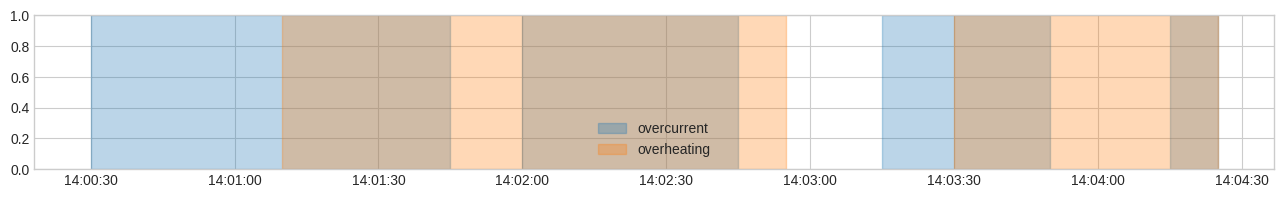

In [63]:
overcurrent = [
    (pd.Timestamp("2019-12-7 14:00:30"), pd.Timestamp("2019-12-7 14:01:45")),
    (pd.Timestamp("2019-12-7 14:02:00"), pd.Timestamp("2019-12-7 14:02:45")),
    (pd.Timestamp("2019-12-7 14:03:15"), pd.Timestamp("2019-12-7 14:03:50")),
    (pd.Timestamp("2019-12-7 14:04:15"), pd.Timestamp("2019-12-7 14:04:25")),
]
overheating = [
    (pd.Timestamp("2019-12-7 14:01:10"), pd.Timestamp("2019-12-7 14:02:55")),
    (pd.Timestamp("2019-12-7 14:03:30"), pd.Timestamp("2019-12-7 14:04:25")),
]
anomaly = {"overcurrent": overcurrent, "overheating": overheating}
plot(anomaly=anomaly, figsize=(16, 2));

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


[(Timestamp('2019-12-07 14:00:30'), Timestamp('2019-12-07 14:02:55')),
 (Timestamp('2019-12-07 14:03:15'), Timestamp('2019-12-07 14:04:25'))]

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


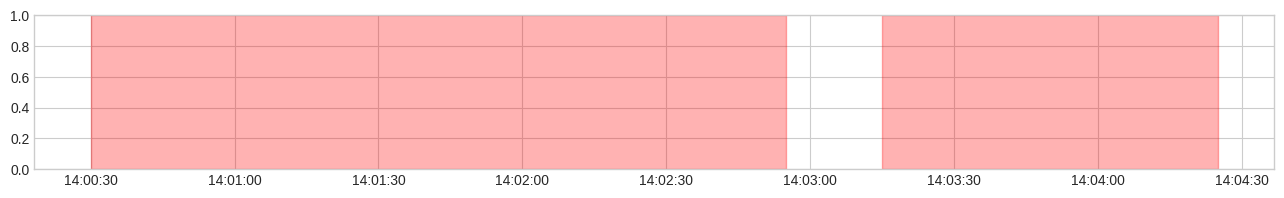

In [64]:
overcurrent_or_overheating = OrAggregator().aggregate(anomaly)
display(overcurrent_or_overheating)
plot(anomaly=overcurrent_or_overheating, anomaly_color="red", legend=False, figsize=(16, 2));

### AndAggregator

`AndAggregator` identifica un punto de tiempo como anómalo sólo si está incluido en todas las listas de anomalías de entrada.

Podría aplicarse para fusionar anomalías en el formato de series binarias.

In [65]:
import numpy as np
anomaly = pd.DataFrame(
    np.array(
        [[False, True, True, False, False],
         [False, False, True, True, False]]).T,
    columns=["overcurrent", "overheating"],
    index=pd.date_range(start="2019-12-7 14:00:00", periods=5, freq="min"))
anomaly

overcurrent  overheating
2019-12-07 14:00:00        False        False
2019-12-07 14:01:00         True        False
2019-12-07 14:02:00         True         True
2019-12-07 14:03:00        False         True
2019-12-07 14:04:00        False        False

In [66]:
from adtk.aggregator import AndAggregator
AndAggregator().aggregate(anomaly)

2019-12-07 14:00:00    False
2019-12-07 14:01:00    False
2019-12-07 14:02:00     True
2019-12-07 14:03:00    False
2019-12-07 14:04:00    False
Freq: T, dtype: bool

También podría aplicarse para fusionar anomalías en formato de lista de eventos.

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int
/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


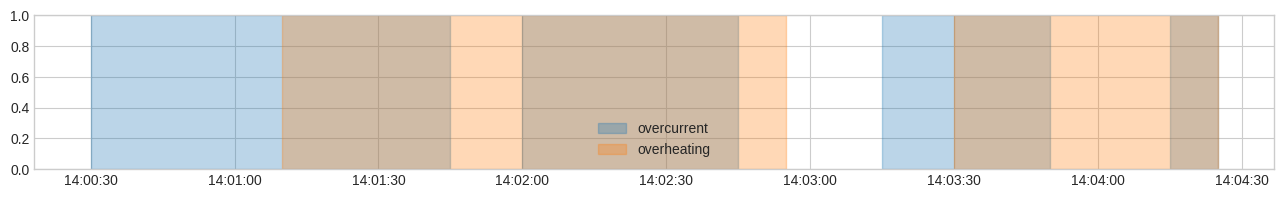

In [67]:
overcurrent = [
    (pd.Timestamp("2019-12-7 14:00:30"), pd.Timestamp("2019-12-7 14:01:45")),
    (pd.Timestamp("2019-12-7 14:02:00"), pd.Timestamp("2019-12-7 14:02:45")),
    (pd.Timestamp("2019-12-7 14:03:15"), pd.Timestamp("2019-12-7 14:03:50")),
    (pd.Timestamp("2019-12-7 14:04:15"), pd.Timestamp("2019-12-7 14:04:25")),
]
overheating = [
    (pd.Timestamp("2019-12-7 14:01:10"), pd.Timestamp("2019-12-7 14:02:55")),
    (pd.Timestamp("2019-12-7 14:03:30"), pd.Timestamp("2019-12-7 14:04:25")),
]
anomaly = {"overcurrent": overcurrent, "overheating": overheating}
plot(anomaly=anomaly, figsize=(16, 2));

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int
/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


[(Timestamp('2019-12-07 14:01:10'), Timestamp('2019-12-07 14:01:45')),
 (Timestamp('2019-12-07 14:02:00'), Timestamp('2019-12-07 14:02:45')),
 (Timestamp('2019-12-07 14:03:30'), Timestamp('2019-12-07 14:03:50')),
 (Timestamp('2019-12-07 14:04:15'), Timestamp('2019-12-07 14:04:25'))]

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


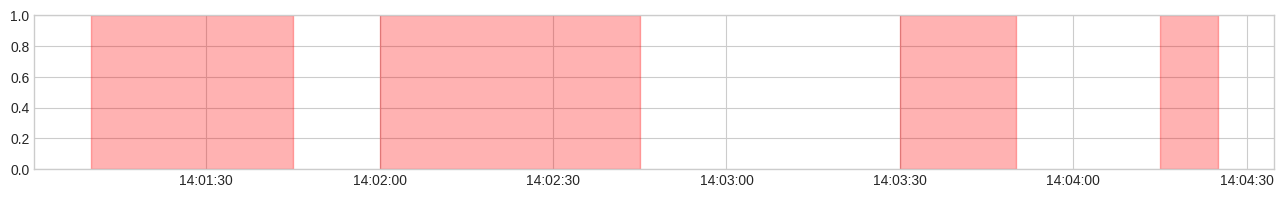

In [68]:
overcurrent_and_overheating = AndAggregator().aggregate(anomaly)
display(overcurrent_and_overheating)
plot(anomaly=overcurrent_and_overheating, anomaly_color="red", legend=False, figsize=(16, 2));

## Pipe

### Pipeline

`Pipeline` encadena transformadores y un detector de forma secuencial.

En el siguiente ejemplo, conectamos un transformer `ClassicSeasonalDecomposition` con un detector `QuantileAD`, cuyo objetivo es detectar desviaciones anómalas del patrón estacional regular en las series temporales.

In [69]:
from adtk.pipe import Pipeline
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.995, low=0.005))
]
pipeline = Pipeline(steps)

<ipython-input-70-0af9dc2655b1>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)


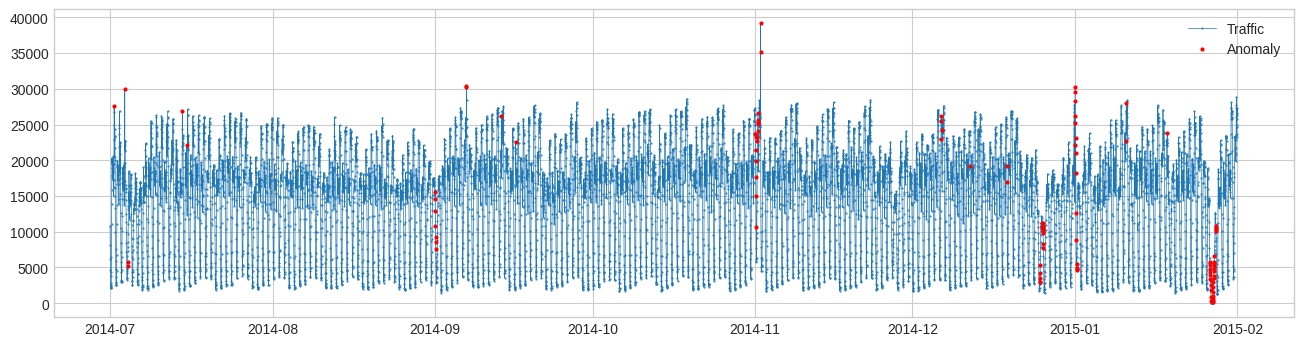

In [70]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

Un usuario tiene la opción de obtener series intermedias y listas de anomalías estableciendo el parámetro `return_intermediate` a True al llamar a los métodos de fitting o predicting de un objeto `Pipeline`.

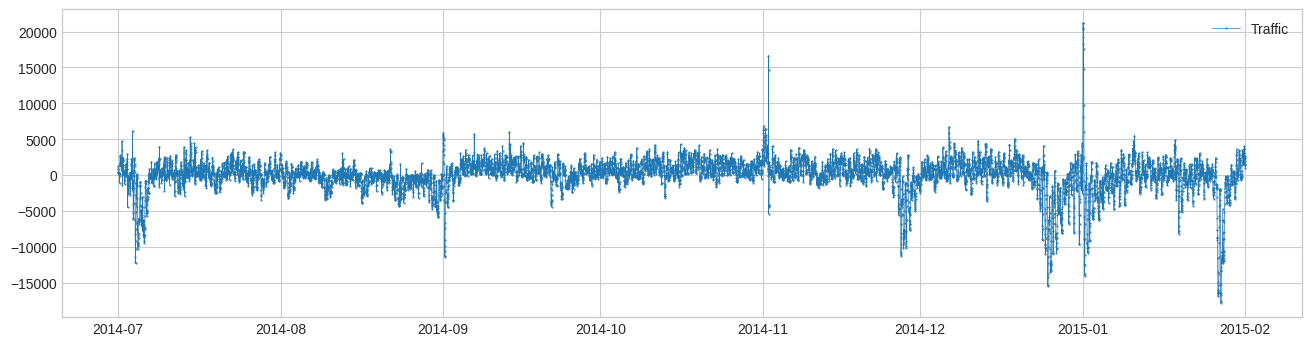

In [71]:
results = pipeline.fit_detect(s, return_intermediate=True)
plot(results["deseasonal"], ts_markersize=1);

### Pipenet

`Pipenet` es una generalización de `Pipeline` para la combinación no secuencial de los componentes del modelo. Algunos detectores del módulo detector están implementados internamente por `Pipenet`.

Por ejemplo, un detector de desplazamiento de nivel single-side (`LevelShiftAD` con el parámetro `side` como "positive" o "negative") se implementa con el siguiente `Pipenet`: Un transformador `DoubleRollingAggregate` con el parámetro `diff` a "l1" se conecta a un detector `InterQuartileRangeAD` para detectar el cambio de nivel en ambos lados, mientras que otro transformador `DoubleRollingAggregate` con el parámetro `diff` a "diff" se conecta a un detector `ThresholdAD` con el parámetro `upper_thresh` a 0 para detectar cambios positivos de nivel. Los cambios de nivel positivos significativos se obtienen entonces con un `AndAggregator`.

In [72]:
from adtk.pipe import Pipenet
steps = {
    "abs_level_change": {
        "model": DoubleRollingAggregate(
            agg="median",
            window=10,
            center=True,
            diff="l1"
        ),
        "input": "original"
    },
    "level_shift": {
        "model": InterQuartileRangeAD(c=3.0),
        "input": "abs_level_change"
    },
    "level_change": {
        "model": DoubleRollingAggregate(
            agg="median",
            window=10,
            center=True,
            diff="diff"
        ),
        "input": "original",
    },
    "positive_level_change": {
        "model": ThresholdAD(high=0),
        "input": "level_change"
    },
    "positive_level_shift": {
        "model": AndAggregator(),
        "input": ["level_shift", "positive_level_change"]
    }
}
pipenet = Pipenet(steps)

El diagrama de flujo de un objeto `Pipenet` se puede visualizar mediante el método `plot_flowchart`.

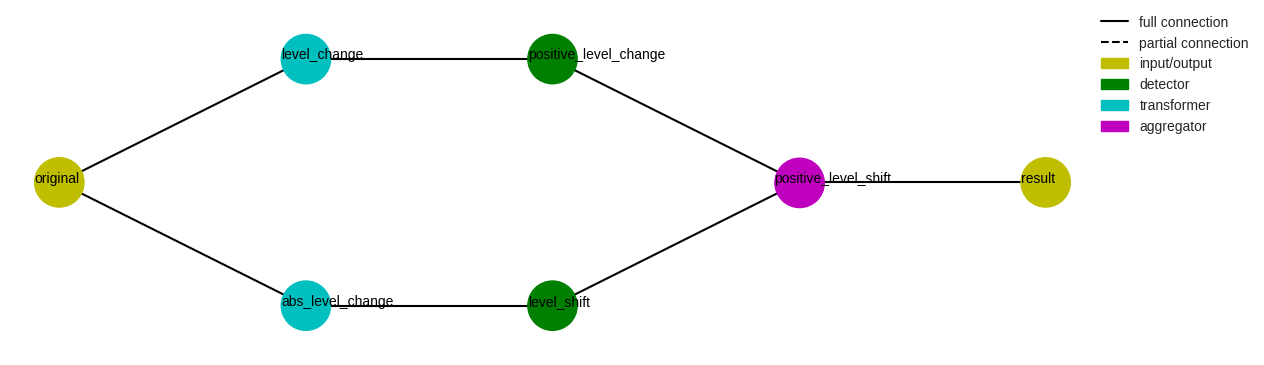

In [73]:
pipenet.plot_flowchart();

Los métodos `summary` y `get_params` pueden ser aplicados para obtener información del pipenet.

In [74]:
pipenet.summary()

name                   model                   input                                     subset
---------------------  ----------------------  ----------------------------------------  --------
abs_level_change       DoubleRollingAggregate  original                                  all
level_change           DoubleRollingAggregate  original                                  all
level_shift            InterQuartileRangeAD    abs_level_change                          all
positive_level_change  ThresholdAD             level_change                              all
positive_level_shift   AndAggregator           ['level_shift', 'positive_level_change']  all


/usr/local/lib/python3.10/dist-packages/adtk/pipe/_pipe.py:1363: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/usr/local/lib/python3.10/dist-packages/adtk/pipe/_pipe.py:1363: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/usr/local/lib/python3.10/dist-packages/adtk/pipe/_pipe.py:1363: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/usr/local/lib/python3.10/dist-packages/adtk/pipe/_pipe.py:1363: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(
/usr/local/lib/python3.10/dist-packages/adtk/pipe/_pipe.py:1363: FutureWarning: The frame.append method is deprecated and will be remove

In [75]:
pipenet.get_params()

{'abs_level_change': {'window': 10,
  'agg': 'median',
  'agg_params': None,
  'center': True,
  'min_periods': None},
 'level_shift': {'c': 3.0},
 'level_change': {'window': 10,
  'agg': 'median',
  'agg_params': None,
  'center': True,
  'min_periods': None},
 'positive_level_change': {'low': None, 'high': 0},
 'positive_level_shift': {}}

<ipython-input-76-e6d48db9831f>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)
/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


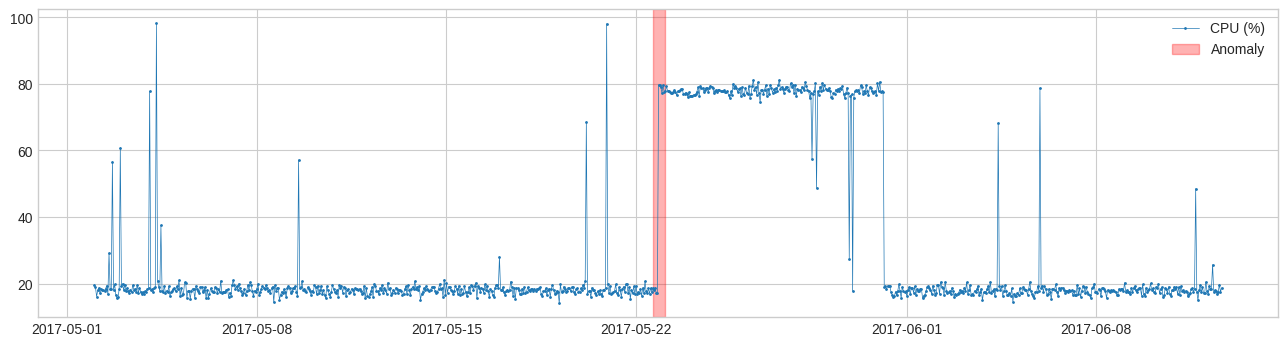

In [76]:
s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)
anomalies = pipenet.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

De forma similar a `Pipeline`, el usuario tiene la opción de obtener series intermedias y listas de anomalías poniendo el parámetro `return_intermediate` a True cuando llama a los métodos de fitting o predicting de un objeto `Pipenet`.

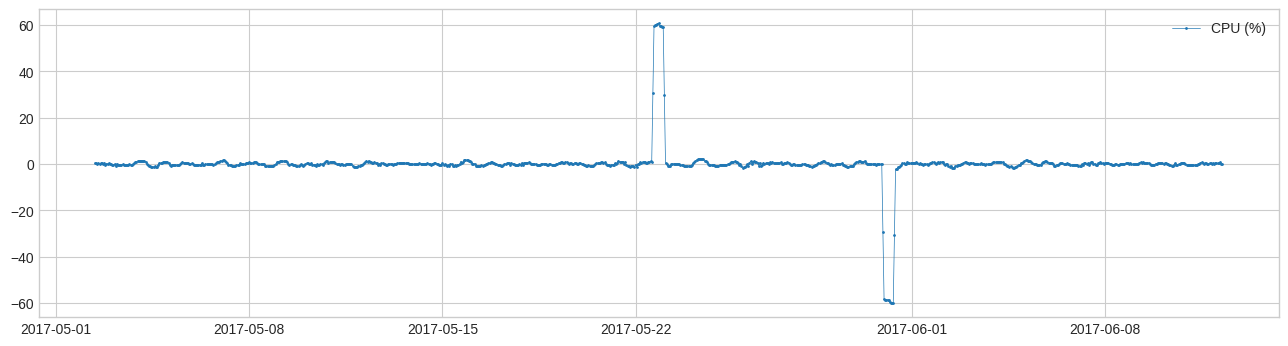

In [77]:
results = pipenet.fit_detect(s, return_intermediate=True)
plot(results["level_change"]);

## Metrics

El módulo `metrics` contiene cuatro tipos de función de scoring que miden la calidad de los resultados de la detección frente a verdaderas anomalías.

Todas las funciones de scoring admiten dos modos:
1. Si las entradas están en forma de etiquetas binarias, cada instante de tiempo con etiqueta 1 se considera un evento anómalo independiente.

2. Si las entradas están en forma de listas de eventos, cada segmento de tiempo anómalo se considera un evento. El cálculo de la función de scoring se basará en la longitud del segmento que aparece tanto en la lista detectada como en la lista verdadera.

Por ejemplo, el `recall` (también conocida como sensibilidad, hit rate o tasa de verdaderos positivos TPR), es la tasa de anomalías verdaderas que se detectan con éxito. En el siguiente ejemplo, hay 13 puntos que son anomalías conocidas. En los resultados de la detección, 9 de los 13 se detectan con éxito. Por lo tanto, el recall es igual a 9/13.

In [78]:
s_constant = pd.Series(0, pd.date_range(start='2017-1-1', periods=24, freq="1d"), name="Time Series")

label_true = pd.Series(
    [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
    pd.date_range(start='2017-1-1', periods=24, freq="1d"),
)
label_pred = pd.Series(
    [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
    pd.date_range(start='2017-1-1', periods=24, freq="1d"),
)

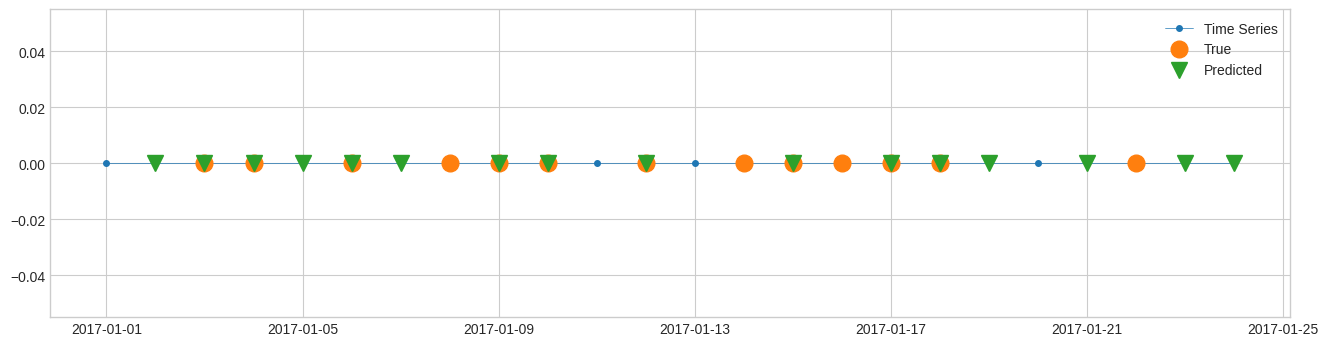

In [79]:
plot(s_constant, ts_markersize=8,
     anomaly={"True": label_true, "Predicted": label_pred},
     anomaly_tag="marker",
     anomaly_markersize=12,
     anomaly_marker={"True": "o", "Predicted": "v"});

In [80]:
from adtk.metrics import recall
recall(label_true, label_pred)

0.6923076923076923

En el siguiente ejemplo hay 6 eventos anómalos (incluyendo 3 eventos instantáneos). Por defecto, se considera que un evento se detecta con éxito si la detección cubre no menos del 50% del segmento. En este ejemplo, los 4 primeros eventos se detectan según esta configuración, y los 2 últimos no se detectan. Por lo tanto, el recall es igual a 4/6.

In [81]:
list_true = [
    (pd.Timestamp("2017-01-03 00:00:00"), pd.Timestamp("2017-01-03 23:59:59.999999999")),
    pd.Timestamp("2017-01-06 00:00:00"),
    (pd.Timestamp("2017-01-08 00:00:00"), pd.Timestamp("2017-01-09 23:59:59.999999999")),
    pd.Timestamp("2017-01-12 00:00:00"),
    (pd.Timestamp("2017-01-14 00:00:00"), pd.Timestamp("2017-01-17 23:59:59.999999999")),
    pd.Timestamp("2017-01-22 00:00:00"),
]
list_pred = [
    (pd.Timestamp("2017-01-02 00:00:00"), pd.Timestamp("2017-01-06 23:59:59.999999999")),
    (pd.Timestamp("2017-01-09 00:00:00"), pd.Timestamp("2017-01-09 23:59:59.999999999")),
    pd.Timestamp("2017-01-12 00:00:00"),
    pd.Timestamp("2017-01-15 00:00:00"),
    (pd.Timestamp("2017-01-17 00:00:00"), pd.Timestamp("2017-01-18 23:59:59.999999999")),
    pd.Timestamp("2017-01-21 00:00:00"),
    (pd.Timestamp("2017-01-23 00:00:00"), pd.Timestamp("2017-01-23 23:59:59.999999999")),
]

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int
/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


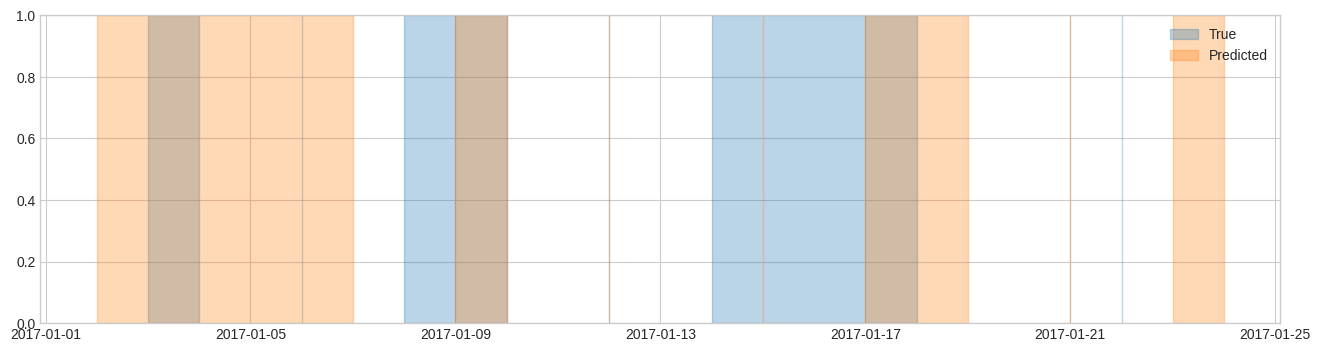

In [82]:
plot(anomaly={"True": list_true, "Predicted": list_pred},);

In [83]:
recall(list_true, list_pred)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int
/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


0.6666666666666666

Si restringimos los criterios de detección con éxito de tal manera que un evento debe tener más del 90% del segmento de tiempo cubierto para ser considerado como detectado con éxito, el tercer evento no es entonces una detección con éxito porque sólo se detecta la mitad de su segmento, y por lo tanto el recall es igual a 3/6.

In [84]:
recall(list_true, list_pred, thresh=0.9)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


0.5

El score `precision` es similar a `recall`, excepto que calcula el porcentaje de anomalías predichas que son verdaderas. También se denomina positive predictive value (VPP).

Si un detector tiende a dar alarmas de más, el `recall` será alto, mientras que `precision` será baja. Si un detector es demasiado estricto, el `recall` será bajo mientras que `precision` será alto.

La puntuación `f1` es un compromiso entre estos dos scores, donde se devuelve la media armónica entre recall y precision.

El score de intersección sobre unión (IoU) `iou` calcula la relación de longitud entre los segmentos de tiempo identificados como anómalos en ambas listas y los identificados por al menos una de las dos listas. En el ejemplo anterior, la unión entre los segmentos anómalos verdaderos y los detectados es de 13 días, mientras que la intersección es de 3 días. Por lo tanto, el IoU es de 3/13.

In [85]:
from adtk.metrics import iou
iou(list_true, list_pred)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


0.2307692307673817

## 3. Procesado de datos

El módulo `data` proporciona algunas funciones para operaciones comunes de procesamiento de series temporales.

### Validación de series temporales

La función `validate_series` comprueba algunas cuestiones críticas comunes que pueden causar problemas si no se arreglan. La función arreglará automáticamente algunos problemas, mientras que dará errores al detectar otros.

Los problemas que se comprobarán y se corregirán automáticamente son los siguientes

- El índice de tiempo no es monótonamente creciente;
- El índice de tiempo contiene marcas de tiempo duplicadas (se corrige manteniendo los primeros valores);
- (opcional) El atributo `freq` del índice de tiempo no está definido;
- (opcional) Las series temporales incluyen columnas de etiquetas categóricas no binarias
  (solucionar convirtiendo las etiquetas categóricas en indicadores binarios, es decir, dummies).

Las cuestiones que se comprobarán y darán lugar a un error son las siguientes

- Tipo incorrecto de objeto de serie temporal (debe ser pandas Series o DataFrame);
- Tipo incorrecto de objeto de índice de tiempo (debe ser pandas DatetimeIndex).

En el siguiente ejemplo, validamos una serie con un tiempo duplicado, un índice no ordenado y una frecuencia no definida.

In [86]:
df = pd.read_csv('./data/invalid_series.csv', index_col="time", parse_dates=True)
df

value category
time                      
2017-01-02    2.0     even
2017-01-01    1.0      odd
2017-01-03    3.0      odd
2017-01-03    3.5      odd
2017-01-06    6.0     even
2017-01-04    4.0     even
2017-01-05    5.0      odd
2017-01-07    7.0      odd
2017-01-04    4.5     even
2017-01-08    8.0     even

In [87]:
df.index

DatetimeIndex(['2017-01-02', '2017-01-01', '2017-01-03', '2017-01-03',
               '2017-01-06', '2017-01-04', '2017-01-05', '2017-01-07',
               '2017-01-04', '2017-01-08'],
              dtype='datetime64[ns]', name='time', freq=None)

In [88]:
from adtk.data import validate_series
df = validate_series(df)
df

value category
time                      
2017-01-01    1.0      odd
2017-01-02    2.0     even
2017-01-03    3.0      odd
2017-01-04    4.0     even
2017-01-05    5.0      odd
2017-01-06    6.0     even
2017-01-07    7.0      odd
2017-01-08    8.0     even

In [89]:
df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08'],
              dtype='datetime64[ns]', name='time', freq='D')

Opcionalmente, la función puede convertir automáticamente las series categóricas en series binarias.

In [90]:
from adtk.data import validate_series
validate_series(df, check_categorical=True)

value  category_even  category_odd
time                                          
2017-01-01    1.0              0             1
2017-01-02    2.0              1             0
2017-01-03    3.0              0             1
2017-01-04    4.0              1             0
2017-01-05    5.0              0             1
2017-01-06    6.0              1             0
2017-01-07    7.0              0             1
2017-01-08    8.0              1             0

### Validación de listas de eventos

La función `validate_events` comprueba la validez de una lista de eventos (una lista de ventanas de tiempo). Los problemas más comunes incluyen una ventana de tiempo no válida, ventanas de tiempo superpuestas o consecutivas, eventos no ordenados, etc.

In [91]:
event_list = [
    (pd.Timestamp('2017-1-2 23:59:59.999999999'), pd.Timestamp('2017-1-1 00:00:00.000000000')),
    (pd.Timestamp('2017-1-2 00:00:00.000000000'), pd.Timestamp('2017-1-3 23:59:59.999999999')),
    (pd.Timestamp('2017-1-8 00:00:00.000000000'), pd.Timestamp('2017-1-9 23:59:59.999999999')),
    pd.Timestamp('2017-1-5 00:00:00.000000000'),
    (pd.Timestamp('2017-1-9 00:00:00.000000000'), pd.Timestamp('2017-1-10 23:59:59.999999999')),
    (pd.Timestamp('2017-1-4 00:00:00.000000000'), pd.Timestamp('2017-1-5 23:59:59.999999999')),
    pd.Timestamp('2017-1-7 00:00:00.000000000')
]
event_list

[(Timestamp('2017-01-02 23:59:59.999999999'),
  Timestamp('2017-01-01 00:00:00')),
 (Timestamp('2017-01-02 00:00:00'),
  Timestamp('2017-01-03 23:59:59.999999999')),
 (Timestamp('2017-01-08 00:00:00'),
  Timestamp('2017-01-09 23:59:59.999999999')),
 Timestamp('2017-01-05 00:00:00'),
 (Timestamp('2017-01-09 00:00:00'),
  Timestamp('2017-01-10 23:59:59.999999999')),
 (Timestamp('2017-01-04 00:00:00'),
  Timestamp('2017-01-05 23:59:59.999999999')),
 Timestamp('2017-01-07 00:00:00')]

In [92]:
from adtk.data import validate_events
validated_event_list = validate_events(event_list)
validated_event_list

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


[(Timestamp('2017-01-02 00:00:00'),
  Timestamp('2017-01-05 23:59:59.999999999')),
 Timestamp('2017-01-07 00:00:00'),
 (Timestamp('2017-01-08 00:00:00'),
  Timestamp('2017-01-10 23:59:59.999999999'))]

### Convertir una serie binaria en una lista de eventos

La función `to_events` convierte una serie binaria en una lista de eventos.

In [93]:
s = pd.Series([True, False, False, True, True, True, False, False, True, False],
              index=pd.date_range(start='2017-1-1', periods=10, freq='D'))
s

2017-01-01     True
2017-01-02    False
2017-01-03    False
2017-01-04     True
2017-01-05     True
2017-01-06     True
2017-01-07    False
2017-01-08    False
2017-01-09     True
2017-01-10    False
Freq: D, dtype: bool

In [94]:
from adtk.data import to_events
to_events(s)

[(Timestamp('2017-01-01 00:00:00', freq='D'),
  Timestamp('2017-01-01 23:59:59.999999999', freq='D')),
 (Timestamp('2017-01-04 00:00:00', freq='D'),
  Timestamp('2017-01-06 23:59:59.999999999', freq='D')),
 (Timestamp('2017-01-09 00:00:00', freq='D'),
  Timestamp('2017-01-09 23:59:59.999999999', freq='D'))]

Para una serie con frecuencia regular, se asume que cada elemento de tiempo en la serie representa un período en lugar de un punto de tiempo instantáneo por defecto. El usuario puede desactivar esta opción estableciendo `freq_as_period` como False.

In [95]:
to_events(s, freq_as_period=False)

[Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-01-04 00:00:00'),
 Timestamp('2017-01-05 00:00:00'),
 Timestamp('2017-01-06 00:00:00'),
 Timestamp('2017-01-09 00:00:00')]

Cuando los puntos de tiempo se tratan independientemente la función no fusionará puntos "consecutivos" por defecto, porque "consecutivo" es un concepto en la línea de tiempo continua. Estableciendo `merge_consecutive` a True, el usuario puede forzar a la función a devolver una ventana de tiempo "consecutiva" en la que los puntos de tiempo positivos próximos entre sí en el índice de tiempo se fusionen en un mismo evento. El usuario debe tener cuidado con el significado de estas ventanas de tiempo.

In [96]:
to_events(s, freq_as_period=False, merge_consecutive=True)

[Timestamp('2017-01-01 00:00:00', freq='D'),
 (Timestamp('2017-01-04 00:00:00', freq='D'),
  Timestamp('2017-01-06 00:00:00', freq='D')),
 Timestamp('2017-01-09 00:00:00', freq='D')]

### Convertir una lista de eventos en una serie binaria

La función `to_labels` convierte una lista de eventos en una serie binaria siguiendo un índice de tiempo determinado.

De forma similar a `to_events`, el argumento `freq_as_period` controla si un elemento de un índice de tiempo con frecuencia regular representa un periodo o un instante de tiempo. Si es un periodo, el periodo se marca como positivo siempre que un evento solape con él. De lo contrario, un instante de tiempo se marca como positivo si un evento lo cubrió.

In [97]:
time_index = pd.date_range(start='2017-1-1', periods=5, freq='D')
time_index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05'],
              dtype='datetime64[ns]', freq='D')

In [98]:
event_list = [(pd.Timestamp('2017-1-2 18:30:00'), pd.Timestamp('2017-1-3 02:00:00')),
              (pd.Timestamp('2017-1-4 20:00:00'), pd.Timestamp('2017-1-5 09:30:00'))]

In [99]:
from adtk.data import to_labels
to_labels(event_list, time_index, freq_as_period=True)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


2017-01-01    False
2017-01-02     True
2017-01-03     True
2017-01-04     True
2017-01-05     True
Freq: D, dtype: bool

In [100]:
to_labels(event_list, time_index, freq_as_period=False)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


2017-01-01    False
2017-01-02    False
2017-01-03     True
2017-01-04    False
2017-01-05     True
Freq: D, dtype: bool

### Expandir la duración de eventos

Cuando se calcula la calidad de un resultado de detección, a veces es aceptable un ligero desfase. La función `expand_events` amplía la duración de los eventos de una lista por un factor determinado, de forma que el scoring sea más tolerante.

En el siguiente ejemplo tenemos un resultado de detección con un desfase de 2 ~ 3 minutos con respecto a la verdadera lista de anomalías. Si aceptamos 5 minutos de desplazamiento hacia delante y hacia atrás, el score es más significativo.

In [101]:
true_anomaly_list = [
    pd.Timestamp('2017-1-2 18:00:00'),
    pd.Timestamp('2017-1-4 20:00:00')]

In [102]:
detected_anomaly_list = [
    pd.Timestamp('2017-1-2 18:02:00'),
    pd.Timestamp('2017-1-4 19:57:00')]

In [103]:
from adtk.metrics import precision
precision(true_anomaly_list, detected_anomaly_list)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


0.0

In [104]:
from adtk.data import expand_events
expanded_true_anomaly_list = expand_events(
    true_anomaly_list, left_expand='5min', right_expand='5min')
expanded_true_anomaly_list

[(Timestamp('2017-01-02 17:55:00'), Timestamp('2017-01-02 18:05:00')),
 (Timestamp('2017-01-04 19:55:00'), Timestamp('2017-01-04 20:05:00'))]

In [105]:
precision(expanded_true_anomaly_list, detected_anomaly_list)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


1.0

### Dividir una serie temporal en segmentos de entrenamiento y de prueba

Una operación crítica al construir modelos de detección de anomalías en series temporales es la división de la serie histórica en training y test.

La función `split_train_test` proporciona cuatro modos de división. El usuario puede elegir entre ellos según el caso específico.

- **Modo 1**. Dividir la serie temporal en n_splits partes de igual longitud, y dividir cada parte en training y test usando train_ratio.

- **Modo 2**. Crear n_splits partes, donde cada parte comienza en t_0 y termina en t_(n/n_splits), donde n va de 0 a n_splits y el primer train_ratio de cada parte es para entrenamiento.

- **Modo 3**. Crear n_splits partes, donde cada parte comienza en t_0. Cada parte tiene len(ts)/(1 + n_splits) puntos de test al final. Cada parte tiene una longitud de n * len(ts)/(1 + n_splits), donde n va de 1 a n_splits.

- **Modo 4**. Crear n_splits partes, donde cada parte comienza en t_0. Cada parte tiene n * len(ts)/(1 + n_splits) puntos de training al principio de la serie temporal, donde n va de 1 a n_splits y los puntos restantes son puntos de test.

**Modo 1**: el tamaño total training + test es constante

<ipython-input-106-325a37be1aa8>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)


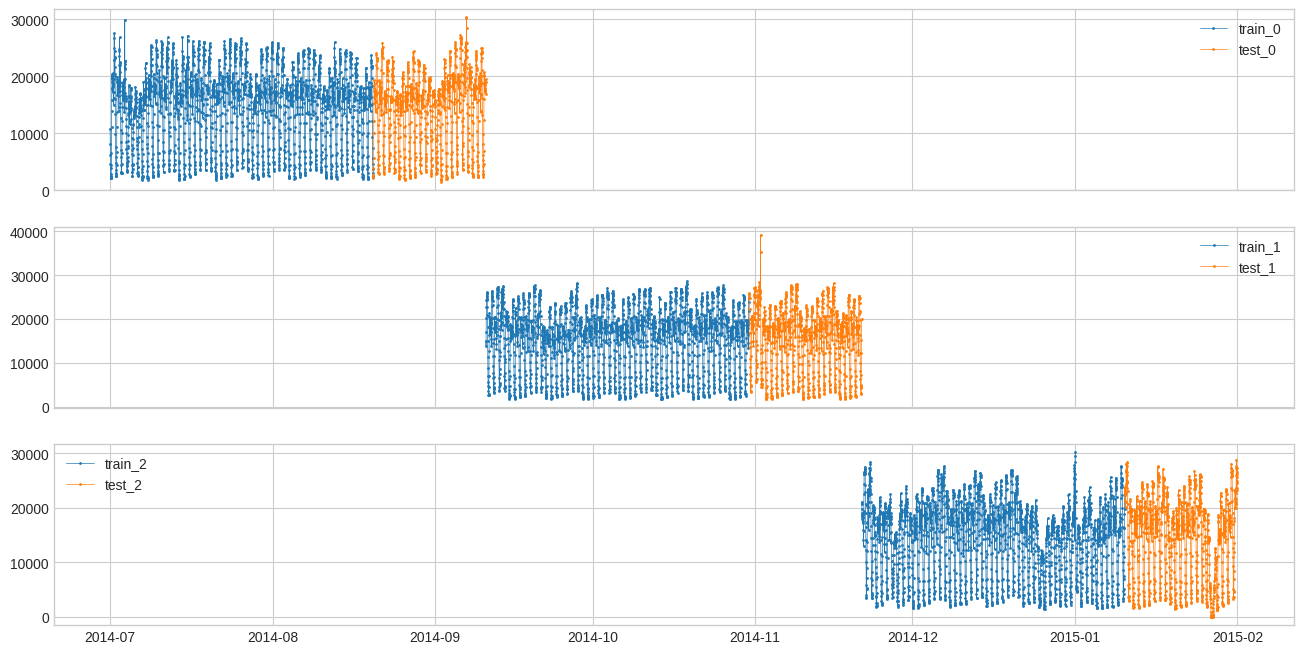

In [106]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)

from adtk.data import split_train_test
splits = split_train_test(s, mode=1, n_splits=3)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df,
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

**Modo 2**: el tamaño de training+test va aumentando, el % de test en cada parte es igual

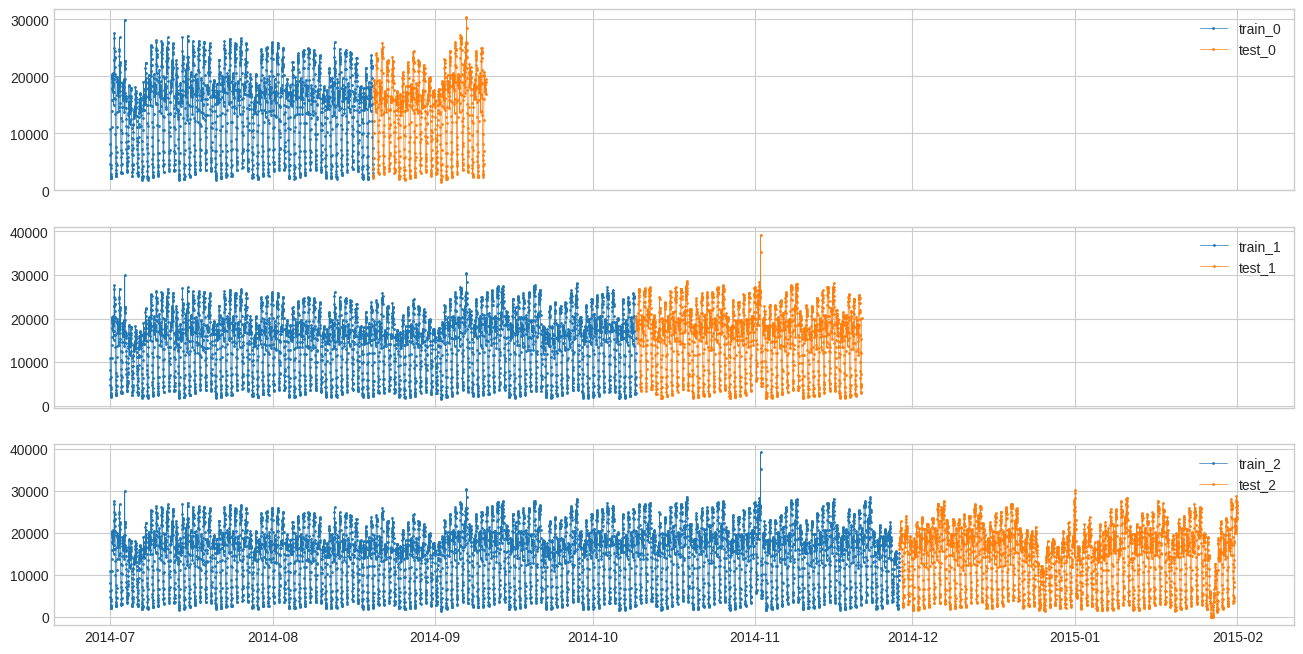

In [107]:
splits = split_train_test(s, mode=2, n_splits=3)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df,
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

**Modo 3**: el tamaño de test es constante y el tamaño de training va aumentando

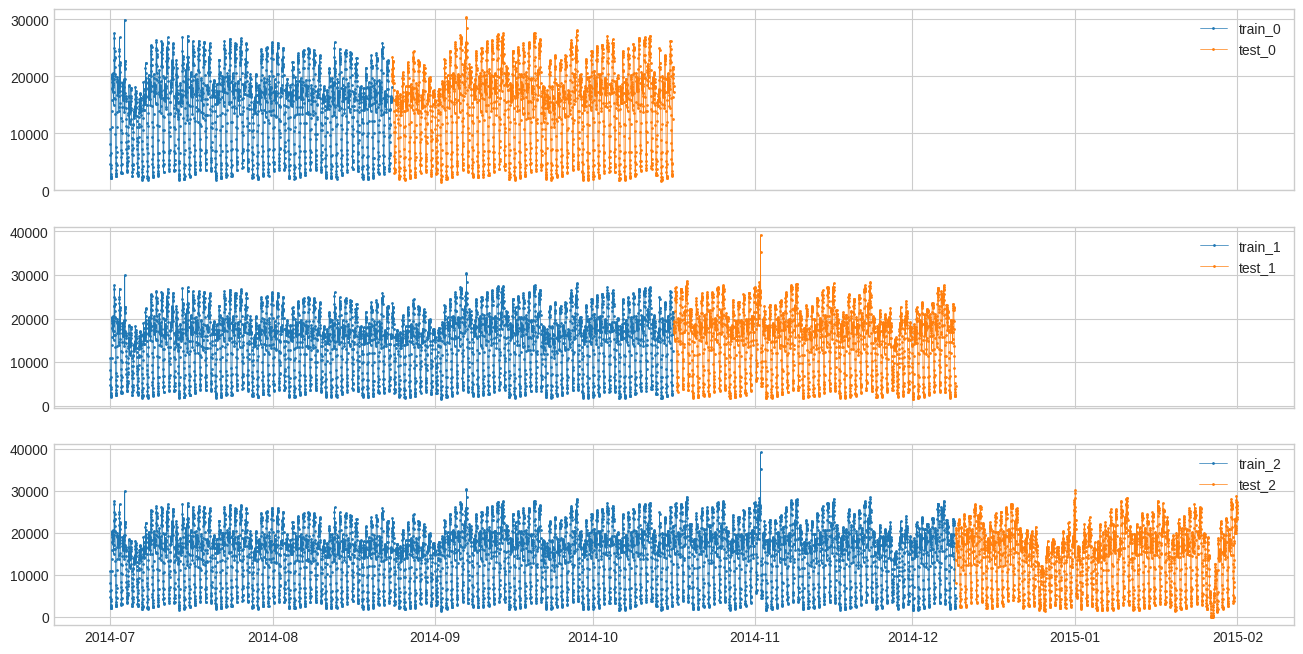

In [108]:
splits = split_train_test(s, mode=3, n_splits=3)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df,
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

**Modo 4**: el tamaño de training+test es constante, el % de test va cambiando

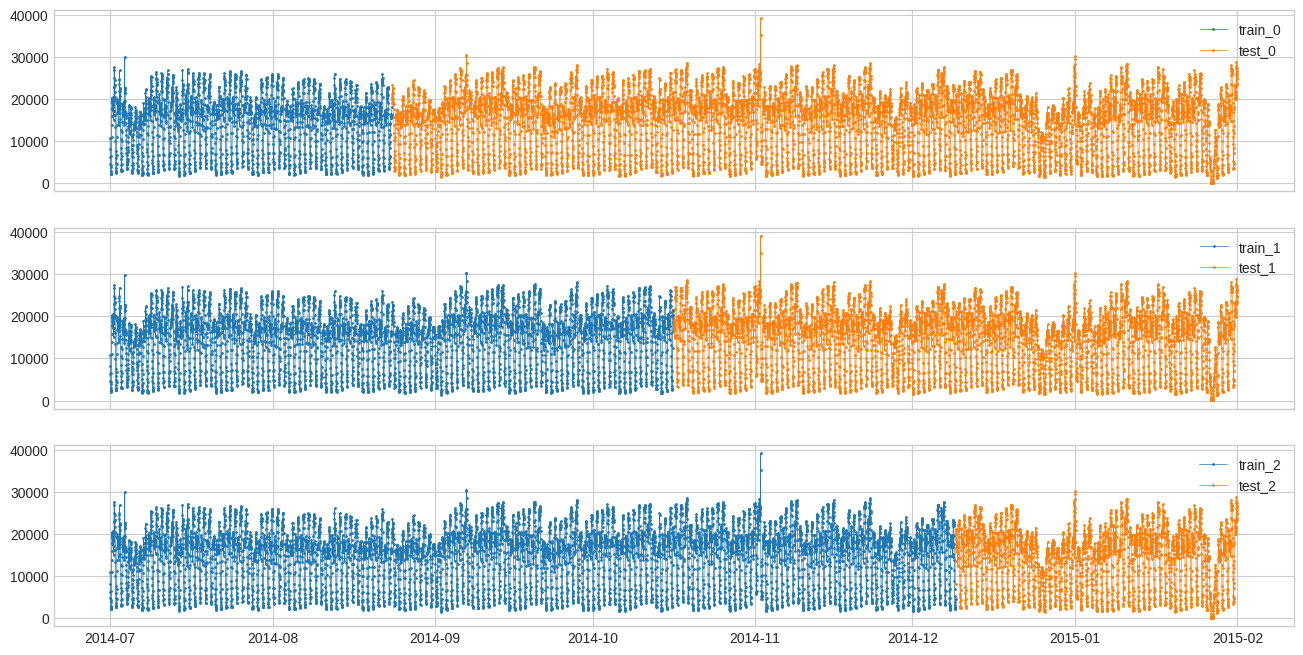

In [109]:
splits = split_train_test(s, mode=4, n_splits=3)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df,
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));